https://stackoverflow.com/questions/53838696/problems-regarding-pyomo-provided-math-functions

https://stackoverflow.com/questions/70048818/optimization-of-a-battery-storage-with-pyomo

https://gitlab.com/diw-evu/emobpy/emobpy/-/blob/master/emobpy/data/evspecs.json

https://github.com/L-Strobel/jointAnalysisCharging/tree/main/chargingmodel

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt#
import matplotlib.axes as axes
import pyomo.environ as pyo 
import pyomo.opt as opt
from IPython.display import clear_output
from pyomo.opt import SolverFactory
import random
from pandas import Timestamp
import pickle
import matplotlib.dates as mdates

## Data input 

In [11]:
V2G = False
short_or_long = "medium" #short: short, medium, long
flex = "constrained" #constrained meaning that late charging cannot be applied to the fullest extent
soc_min = 0 #level that should preferably be reached as soon as possible

In [12]:
#emobpy import
processing_path = os.getcwd()
os.chdir(f"/Users/Jarusch/Documents/EES/{short_or_long}")
    #f"../emobpy/{s hort_or_long}")

data_path = os.getcwd()
os.chdir(processing_path)
pics = os.path.join(processing_path, "Pictures","V2G" if V2G else "G2V", short_or_long)
if soc_min >0: 
    os.makedirs(os.path.join(processing_path, "Pictures", f"{soc_min}"), exist_ok = True)
    pics = os.path.join(processing_path, "Pictures", f"{soc_min}")

pics_input = os.path.join(pics, "input")

    

consumption_ts = pd.read_pickle(os.path.join(data_path,  "consumption_new"))
consumption_ts = consumption_ts*100 
availability_ts = pd.read_pickle(os.path.join(data_path, "availability_new"))
car_properties_raw = pd.read_pickle(os.path.join(data_path,  "properties_new")) 

profiles = min(consumption_ts.shape[1], availability_ts.shape[1], car_properties_raw.shape[1])

time_steps = len(availability_ts.dropna().index)

In [13]:
#emobpy import
processing_path = os.getcwd()
os.chdir(f"/Users/Jarusch/Documents/EES/{short_or_long}")
    #f"../emobpy/{s hort_or_long}")

data_path = os.getcwd()
os.chdir(processing_path)
pics = os.path.join(processing_path, "Pictures","V2G" if V2G else "G2V", short_or_long)
if soc_min >0: 
    os.makedirs(os.path.join(processing_path, "Pictures", f"{soc_min}"), exist_ok = True)
    pics = os.path.join(processing_path, "Pictures", f"{soc_min}")

pics_input = os.path.join(pics, "input")

    

consumption_ts_old = pd.read_pickle(os.path.join(data_path,  "consumption_old"))
consumption_ts_old = consumption_ts*100 
availability_ts_old = pd.read_pickle(os.path.join(data_path, "availability_old"))
car_properties_raw_old = pd.read_pickle(os.path.join(data_path,  "properties_old")) 

profiles = min(consumption_ts.shape[1], availability_ts.shape[1], car_properties_raw.shape[1])

time_steps = len(availability_ts.dropna().index)

In [19]:
pd.concat([car_properties_raw, car_properties_raw_old
          ], axis=1).to_pickle((os.path.join(data_path, "properties")))

In [3]:
#emobpy import
processing_path = os.getcwd()
if short_or_long == "short": 
    os.chdir("../emobpy/short")
elif short_or_long == "medium": 
    os.chdir("../emobpy/medium")
else:
    os.chdir("../emobpy/long")
data_path = os.getcwd()
os.chdir(processing_path)
pics = os.path.join(processing_path, "Pictures","V2G" if V2G else "G2V", short_or_long)
if soc_min >0: 
    os.mkdir( os.path.join(processing_path, f"{soc_min}"))
    os.chdir(f"../{soc_min}")
    pics = os.getcwd()

pics_input = os.path.join(pics, "input")

    

consumption_ts = pd.read_pickle(os.path.join(data_path,  "consumption"))
consumption_ts = consumption_ts*1000/4  #W/h --> kW/15min_timestep
availability_ts = pd.read_pickle(os.path.join(data_path, "availability"))
car_properties_raw = pd.read_pickle(os.path.join(data_path,  "properties")) 

profiles = min(consumption_ts.shape[1], availability_ts.shape[1], car_properties_raw.shape[1])
if short_or_long == "long":
    time_steps = len(availability_ts.dropna().index)
else: 
    days = 12
    time_steps = consumption_ts[consumption_ts.index.day<=days].shape[0]


In [4]:
car_properties_raw.iloc[0] = 1
car_properties_raw.iloc[1] = 1

In [5]:
#consumption = pd.DataFrame(data = np.array([[0, 0.5], [0, 0.5], [0.5, 0], [0.5, 0]]), columns = ["c_1[kW]", "c_2[kW]"])
#power = pd.DataFrame(pd.DataFrame(data = np.array([[1, 0], [1, 0], [0, 1], [0, 1]]), columns = ["p_1 [kW]", "p_2 [kW]"]))

#kWh / 15 min timestep
consumption_raw, power_raw, car_properties_raw = consumption_ts.iloc[:time_steps, :profiles].dropna(), availability_ts.iloc[:time_steps, :profiles].dropna(), car_properties_raw.iloc[:, :profiles].dropna()
neg_power_magnitude_raw = power_raw

#set datetime indexes 
index = consumption_ts.index[:time_steps]
consumption_raw.index, power_raw.index, neg_power_magnitude_raw.index = index, index, index

In [6]:
step_duration = int(pd.infer_freq(index)[:-1]) / 60  #parts of an hour

## Data plausibility

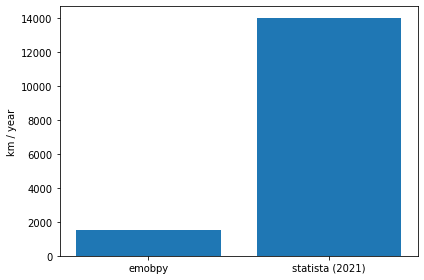

In [7]:
#average consumption of 200Wh per km  https://de.statista.com/statistik/daten/studie/183003/umfrage/pkw---gefahrene-kilometer-pro-jahr/, https://ev-database.de/cheatsheet/energy-consumption-electric-car 
#median in Germany is at about 11000 km per year
if soc_min ==0:  
    specific_consumption = 15 #for consumtion [kWh]  / [kWh/km]  = km
    scale = 365/len(consumption_raw.resample("D").sum().index)

    plot = plt.bar(
        ["emobpy", "statista (2021)"], [consumption_raw.sum(0).mean()*scale/specific_consumption, 14000]
           )
    plt.ylabel("km / year")
    plt.tight_layout()

    plt.savefig(os.path.join(pics_input, 'annual_mileage.png'),bbox_inches = "tight")

In [8]:
np.unique(power_raw.values) 

array([0.0, 3.33, 19.8], dtype=object)

In [9]:
#flexibility only available at home or at workplace 
flex_dict = {
    3.33 : {
        "time_steps" : 1    
    }
}
flex_dict[3.33]

{'time_steps': 1}

#power ratings are mostly between 3 and 20 kW 
if soc_min ==0:  
    ts = power_raw.loc[(index.day<=7) & (index.month==1)].resample("12h").mean()
    fig, ax = plt.subplots(figsize=(8, 3.5))
    ax.boxplot(
        ts.transpose(), labels= [d[:3] + "/" + str(h) for d, h in zip(ts.index.day_name(), ts.index.hour)],
          )

    plt.ylabel('power rating [kW]')

    fig.tight_layout()
    plt.savefig(os.path.join(pics_input, 'average_power_rating.png'), bbox_inches = "tight")

if soc_min ==0:  
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ts = power_raw.mean(1).resample("D").mean()
    ts_2 =  consumption_raw.mean(1).resample("D").mean()

    ax = ts.plot(ylabel="kW grid_availability", label = "grid_availability")

    ax2 = ax.twinx()
    ax2.spines['right'].set_position(('axes',  1))

    ax2 = ts_2.plot(ylabel="kW consumption", color = "orange", label = "consumption")

    #.loc[index.day<=7].resample("2h").

    for i, s in enumerate([ts, ts_2]):
        if i == 0: 
            ax.set_ylim(s.min(), s.max())
        else:
            ax2.set_ylim(s.min(), s.max())
        step_size = (s.max() - s.min())/5
        ax.set_yticks(np.arange(s.min(), s.max(), step_size))


    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc="best", bbox_to_anchor=(1,1.3))

    ax.grid('on', which='minor', axis='x' )


    fig.tight_layout()


    plt.savefig(os.path.join(pics_input, 'consumtion_power_availability.png'), bbox_inches = "tight")

bottom = 0
rating = 1
rating_weighted = True
station_dict = {0.0 : "none",
               3.33 : "home",
               19.8: "public"}
fig, ax = plt.subplots(figsize=(8, 3.5))
i = 0

for r in np.unique(power_raw.values):
    if rating_weighted == True: 
        rating = r
        if (r != 0): 
            next_bottom = bottom+power_raw[power_raw==r].count(1)*rating 
        else: continue
        
    else: 
        next_bottom = bottom+power_raw[power_raw==r].count(1)*rating / power_raw.shape[1] *100
    if r in station_dict.keys(): l = station_dict[r] 
    else: 
        l = f'fast_{1}'
        i +=1
    
    plt.fill_between(x = power_raw.index,
                y1 = bottom,
                y2 = next_bottom,
                alpha = 0.2,
                label = l)
    bottom = next_bottom

ax.xaxis.set_major_locator(mdates.DayLocator(interval = 1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%D'))
plt.ylabel('kW' if rating_weighted else "%")
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.5))

if soc_min ==0: plt.savefig(os.path.join(pics_input, f'home_charging_shares{"_per_cent" if rating_weighted else "_kw"}.png'),bbox_inches = "tight") 

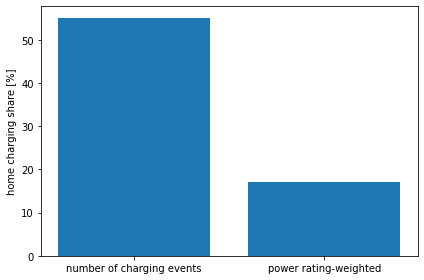

In [10]:
if soc_min ==0:  
    home_share_events = power_raw[power_raw==3.33].count().sum() / power_raw[power_raw>0].count().sum()*100
    home_share_rating = power_raw[power_raw==3.33].sum().sum() / power_raw.sum().sum()*100


    plot = plt.bar(
        ["number of charging events", "power rating-weighted"], [home_share_events, home_share_rating]
           )
    plt.ylabel("home charging share [%]")
    plt.tight_layout()

    plt.savefig(os.path.join(pics_input, 'home_charging_shares.png'),bbox_inches = "tight")

In [11]:
#https://www.agora-energiewende.de/en/service/recent-electricity-data/chart/power_generation/08.08.2021/08.08.2022/today/
german_peak = 73.3 #MW 30.11.2021
national_fleet_size = 10**6
scaling = national_fleet_size / consumption_raw.shape[0]
peak_load = consumption_raw.sum(1).nlargest(1).sum() #kW
print(peak_load) #kW 
print(peak_load*scaling*10**(-3) / german_peak) #kW --> MW

9796.492299610745
3.814191810260403


In [12]:
#plausibility:
#is the sum of the highest 10 consumption value assumed for one hour as constant lower than the average battery size?
(consumption_raw).mean(1).nlargest(10).sum() / car_properties_raw.iloc[2].mean()

0.28915364863543347

# EES-transformation: Generating uncontrolled and latest charging ts

In [13]:
#set same names for columns
power_raw.columns = consumption_raw.columns
neg_power_magnitude_raw.columns = consumption_raw.columns
car_properties_raw.columns = consumption_raw.columns

In [14]:
solution_dict = {}
ees_constraints= pd.DataFrame()
M = 10000
failed_profiles = []

count = 0
for car in consumption_raw.columns.unique():
    try: 
        car_list = consumption_raw[car].columns
    except AttributeError as a:
        car_list = [car]
        
    for i, c in enumerate(car_list):
        print(count)
        count =+ 1
        print(i) 
        print(c)
        
        if type(consumption_raw[c]) == pd.core.series.Series:
            consumption = consumption_raw[c]
            power = power_raw[car]
            neg_power_magnitude = neg_power_magnitude_raw[c]
            car_properties = car_properties_raw[c]

        else: 
            consumption = consumption_raw[c].iloc[:,i]
            power= power_raw[car].iloc[:,i]
            neg_power_magnitude= neg_power_magnitude_raw[c].iloc[:,i]
            car_properties= car_properties_raw[c].iloc[:,i]
            

        solution_dict[car+str(i)] = {}
        battery_capacity = car_properties.loc["battery_capacity"]
        level_0 = car_properties["soc_init"]*battery_capacity
        level_T = car_properties.loc["soc_end"]*battery_capacity

        for model_type in ["m_early", "m_late"]:
            if (model_type == "m_late") & (car+str(i) in failed_profiles): 
                pass
            else:
                #Initialize model
                m = pyo.ConcreteModel()
                
                #initialize sets
                m.t = pyo.Set(initialize = index, ordered = True)

                #Initialize parameter
                m.consumption = pyo.Param(m.t, initialize=consumption.to_dict())
                m.power = pyo.Param(m.t, initialize=power.to_dict()) 
                m.neg_power = pyo.Param(m.t, initialize=neg_power_magnitude.to_dict()) 

                #Initialize variables
                m.CHARGE = pyo.Var(m.t, within = pyo.NonNegativeReals)
                m.SLACK = pyo.Var(m.t, within = pyo.NonNegativeReals)
                m.DISCHARGE = pyo.Var(m.t, within = pyo.NonNegativeReals)
                m.LEVEL = pyo.Var(m.t, within = pyo.NonNegativeReals, 
                                  bounds = (0,battery_capacity))
                
                if ((model_type == "m_late") & (flex=="constrained")): ###
                    con = consumption_raw[car].iloc[:, i]
                    ava = power_raw[car].iloc[:, i]
                    
                    public_index = ava[(ava!=3.33)].index
                    dep_home_index = con[((con==0) & (con.shift(-1) > 0) == True) & (ava==3.33)].index
                    
                    m.t_pub = pyo.Set(initialize = public_index, ordered = True)
                    m.t_dep_home = pyo.Set(initialize = dep_home_index, ordered = True)
                    
                    def full_before_next_trip(m, t_dep): ####
                        if t_dep in  index[:2]:
                            return pyo.Constraint.Skip
                        else:
                            t_dep_1 = pd.Timestamp(t_dep) - pd.Timedelta(flex_dict[3.33]["time_steps"]*pd.infer_freq(index))
                            return m.LEVEL[t_dep_1] >= solution_dict[car+str(i)]["m_early"]["level"].loc[t_dep_1]
                    m.Full_before_next_trip = pyo.Constraint(m.t_dep_home, rule=full_before_next_trip)
                            
                    def public_uncontrolled(m, t_dep):  
                        return m.LEVEL[t_dep] >= solution_dict[car+str(i)]["m_early"]["level"].loc[t_dep]
                    m.Public_uncontrolled = pyo.Constraint(m.t_pub, rule=public_uncontrolled)
                    
                #level constraints
                def recursive_level(m, t):
                    if t == index[0]:
                        return m.LEVEL[t] == level_0 + (m.CHARGE[t] - m.DISCHARGE[t] - m.consumption[t] )*step_duration
                    else:    
                        return m.LEVEL[t] == m.LEVEL[pd.Timestamp(t) - 
                                                         pd.Timedelta(pd.infer_freq(index))] + (
                            m.CHARGE[t] - m.DISCHARGE[t] - m.consumption[t] )*step_duration   
                m.Recursive_level = pyo.Constraint(m.t, rule = recursive_level)

                def final_level(m, t):
                    if t == index[-1]:
                        return m.LEVEL[t] == level_T
                    else: 
                        return pyo.Constraint.Skip
                m.Final_level = pyo.Constraint(m.t, rule=final_level)

                #bidirectional charging 
                def neg_power_min(m, t):
                    if V2G == True:
                        return m.DISCHARGE[t] <= m.neg_power[t] 
                    else:
                        return m.DISCHARGE[t] ==0
                m.Neg_power_min_restriction = pyo.Constraint(m.t, rule=neg_power_min)

                def power_max(m, t):
                    return m.CHARGE[t] <= m.power[t]   
                m.Power_max_restriction = pyo.Constraint(m.t, rule=power_max)

                def avoid_min_level(m, t):
                    return m.LEVEL[t] + m.SLACK[t] >= battery_capacity*soc_min
                m.Avoid_min_level = pyo.Constraint(m.t, rule=avoid_min_level)

                def battery_level_sum(m, t):    
                    if model_type == "m_late":
                        return sum(m.LEVEL[t] + M * m.SLACK[t] for t in m.t) 
                    else:
                        return sum(m.LEVEL[t] for t in m.t) 
                if model_type == "m_late": sense = pyo.minimize
                else: sense = pyo.maximize


                m.Obj = pyo.Objective(rule=battery_level_sum, sense=sense)

                #find solver
                solvername='glpk'

                #prepare solver
                optimizer = opt.SolverFactory(solvername) 
                solved_model = optimizer.solve(m)      ##tee=True   

                if pd.DataFrame.from_dict(m.LEVEL.extract_values(), orient='index')[0][-1]== None:
                    failed_profiles.append(car+str(i))
                    print("failed")
                else:    
                    print("succeeded")
                    level_series = pd.concat([
                        pd.Series(0, index=[index[0]-pd.Timedelta(pd.infer_freq(index))]),
                        pd.DataFrame.from_dict(m.LEVEL.extract_values(), orient='index')[0]
                    ], axis=0)
                    charge_df = pd.DataFrame.from_dict(m.CHARGE.extract_values(), orient='index', columns = [car])
                    discharge_df = pd.DataFrame.from_dict(m.DISCHARGE.extract_values(), orient='index', columns = [car])

                    #store data in dictionary
                    solution_dict[car+str(i)][model_type] = {}
                    solution_dict[car+str(i)][model_type]["level"] = level_series
                    solution_dict[car+str(i)][model_type]["charge"] = charge_df
                    solution_dict[car+str(i)][model_type]["discharge"] = discharge_df
                    level_index = solution_dict[car+str(i)][model_type]["level"].index
solution_dict["failed_profiles"] = failed_profiles

0
0
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5
Tesla/Model_3_Long_Range_AWD/2019
failed
1
6
Tesla/Model_3_Long_Range_AWD/2019
failed
1
7
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
8
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
9
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
10
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
11
Tesla/Model_3_Long_Range_AWD/2019
failed
1
12
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
13
Tesla/Model_3_Long_Range_AWD/2019
failed
1
14
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
15
Tesla/Model_3_Long_Range_AWD/2019
failed
1
16
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
17
Tesla/Model_3_Long_Range_AWD/2019
failed
1
18
Tesla/Model_3_Long_Range_AWD/2019
failed
1
19
Tesla/Model_3_Long_Range_AW

failed
1
162
Tesla/Model_3_Long_Range_AWD/2019
failed
1
163
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
164
Tesla/Model_3_Long_Range_AWD/2019
failed
1
165
Tesla/Model_3_Long_Range_AWD/2019
failed
1
166
Tesla/Model_3_Long_Range_AWD/2019
failed
1
167
Tesla/Model_3_Long_Range_AWD/2019
failed
1
168
Tesla/Model_3_Long_Range_AWD/2019
failed
1
169
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
170
Tesla/Model_3_Long_Range_AWD/2019
failed
1
171
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
172
Tesla/Model_3_Long_Range_AWD/2019
failed
1
173
Tesla/Model_3_Long_Range_AWD/2019
failed
1
174
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
175
Tesla/Model_3_Long_Range_AWD/2019
failed
1
176
Tesla/Model_3_Long_Range_AWD/2019
failed
1
177
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
178
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
179
Tesla/Model_3_Long_Range_AWD/2019
failed
1
180
Tesla/Model_3_Long_Range_AWD/2019
failed
1
181
Tesla/Model_3_Lo

failed
1
323
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
324
Tesla/Model_3_Long_Range_AWD/2019
failed
1
325
Tesla/Model_3_Long_Range_AWD/2019
failed
1
326
Tesla/Model_3_Long_Range_AWD/2019
failed
1
327
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
328
Tesla/Model_3_Long_Range_AWD/2019
failed
1
329
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
330
Tesla/Model_3_Long_Range_AWD/2019
failed
1
331
Tesla/Model_3_Long_Range_AWD/2019
failed
1
332
Tesla/Model_3_Long_Range_AWD/2019
failed
1
333
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
334
Tesla/Model_3_Long_Range_AWD/2019
failed
1
335
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
336
Tesla/Model_3_Long_Range_AWD/2019
failed
1
337
Tesla/Model_3_Long_Range_AWD/2019
failed
1
338
Tesla/Model_3_Long_Range_AWD/2019
failed
1
339
Tesla/Model_3_Long_Range_AWD/2019
failed
1
340
Tesla/Model_3_Long_Range_AWD/2019
failed
1
341
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
342
Tesla/Model_3_Lo

succeeded
succeeded
1
485
Tesla/Model_3_Long_Range_AWD/2019
failed
1
486
Tesla/Model_3_Long_Range_AWD/2019
failed
1
487
Tesla/Model_3_Long_Range_AWD/2019
failed
1
488
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
489
Tesla/Model_3_Long_Range_AWD/2019
failed
1
490
Tesla/Model_3_Long_Range_AWD/2019
failed
1
491
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
492
Tesla/Model_3_Long_Range_AWD/2019
failed
1
493
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
494
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
495
Tesla/Model_3_Long_Range_AWD/2019
failed
1
496
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
497
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
498
Tesla/Model_3_Long_Range_AWD/2019
failed
1
499
Tesla/Model_3_Long_Range_AWD/2019
failed
1
500
Tesla/Model_3_Long_Range_AWD/2019
failed
1
501
Tesla/Model_3_Long_Range_AWD/2019
failed
1
502
Tesla/Model_3_Long_Range_AWD/2019
failed
1
503
Tesla/Model_3_Long_Range_AWD/2019
failed
1
504
Tes

failed
1
645
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
646
Tesla/Model_3_Long_Range_AWD/2019
failed
1
647
Tesla/Model_3_Long_Range_AWD/2019
failed
1
648
Tesla/Model_3_Long_Range_AWD/2019
failed
1
649
Tesla/Model_3_Long_Range_AWD/2019
failed
1
650
Tesla/Model_3_Long_Range_AWD/2019
failed
1
651
Tesla/Model_3_Long_Range_AWD/2019
failed
1
652
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
653
Tesla/Model_3_Long_Range_AWD/2019
failed
1
654
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
655
Tesla/Model_3_Long_Range_AWD/2019
failed
1
656
Tesla/Model_3_Long_Range_AWD/2019
failed
1
657
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
658
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
659
Tesla/Model_3_Long_Range_AWD/2019
failed
1
660
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
661
Tesla/Model_3_Long_Range_AWD/2019
failed
1
662
Tesla/Model_3_Long_Range_AWD/2019
failed
1
663
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
664
Tes

failed
1
805
Tesla/Model_3_Long_Range_AWD/2019
failed
1
806
Tesla/Model_3_Long_Range_AWD/2019
failed
1
807
Tesla/Model_3_Long_Range_AWD/2019
failed
1
808
Tesla/Model_3_Long_Range_AWD/2019
failed
1
809
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
810
Tesla/Model_3_Long_Range_AWD/2019
failed
1
811
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
812
Tesla/Model_3_Long_Range_AWD/2019
failed
1
813
Tesla/Model_3_Long_Range_AWD/2019
failed
1
814
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
815
Tesla/Model_3_Long_Range_AWD/2019
failed
1
816
Tesla/Model_3_Long_Range_AWD/2019
failed
1
817
Tesla/Model_3_Long_Range_AWD/2019
failed
1
818
Tesla/Model_3_Long_Range_AWD/2019
failed
1
819
Tesla/Model_3_Long_Range_AWD/2019
failed
1
820
Tesla/Model_3_Long_Range_AWD/2019
failed
1
821
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
822
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
823
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
824
Tesla/Model_3_Lo

failed
1
965
Tesla/Model_3_Long_Range_AWD/2019
failed
1
966
Tesla/Model_3_Long_Range_AWD/2019
failed
1
967
Tesla/Model_3_Long_Range_AWD/2019
failed
1
968
Tesla/Model_3_Long_Range_AWD/2019
failed
1
969
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
970
Tesla/Model_3_Long_Range_AWD/2019
failed
1
971
Tesla/Model_3_Long_Range_AWD/2019
failed
1
972
Tesla/Model_3_Long_Range_AWD/2019
failed
1
973
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
974
Tesla/Model_3_Long_Range_AWD/2019
failed
1
975
Tesla/Model_3_Long_Range_AWD/2019
failed
1
976
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
977
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
978
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
979
Tesla/Model_3_Long_Range_AWD/2019
failed
1
980
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
981
Tesla/Model_3_Long_Range_AWD/2019
failed
1
982
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
983
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succee

succeeded
succeeded
1
1126
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1127
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1128
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1129
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1130
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1131
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1132
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1133
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1134
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1135
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1136
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1137
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1138
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1139
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1140
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1141
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1142
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1143
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1144
Tesla/Model_3_Long_Range_AWD/20

failed
1
1287
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1288
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1289
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1290
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1291
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1292
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1293
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1294
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1295
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1296
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1297
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1298
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1299
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1300
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1301
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1302
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1303
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1304
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1305
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1

failed
1
1446
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1447
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1448
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1449
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1450
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1451
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1452
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1453
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1454
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1455
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1456
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1457
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1458
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1459
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1460
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1461
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1462
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1463
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1464
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1

failed
1
1607
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1608
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1609
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1610
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1611
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1612
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1613
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1614
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1615
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1616
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1617
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1618
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1619
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1620
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1621
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1622
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1623
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1624
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1625
Tesla/Model_3_Long_Range_AWD/20

succeeded
succeeded
1
1767
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1768
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1769
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1770
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1771
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1772
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1773
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1774
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1775
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1776
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1777
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1778
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1779
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1780
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1781
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1782
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1783
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1784
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1785
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1786
Tesla/Model_3_Long_Ran

failed
1
1926
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1927
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1928
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1929
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1930
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1931
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1932
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1933
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1934
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1935
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1936
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1937
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1938
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1939
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1940
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1941
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1942
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1943
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1944
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1

succeeded
succeeded
1
2087
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2088
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2089
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2090
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2091
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2092
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2093
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2094
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2095
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2096
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2097
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2098
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2099
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2100
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2101
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2102
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2103
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2104
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2105
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2

failed
1
2247
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2248
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2249
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2250
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2251
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2252
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2253
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2254
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2255
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2256
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2257
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2258
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2259
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2260
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2261
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2262
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2263
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2264
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2265
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2266
Tesla/Mod

failed
1
2409
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2410
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2411
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2412
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2413
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2414
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2415
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2416
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2417
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2418
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2419
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2420
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2421
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2422
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2423
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2424
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2425
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2426
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2427
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2428
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succ

succeeded
1
175
Volkswagen/ID.3/2020
succeeded
succeeded
1
176
Volkswagen/ID.3/2020
failed
1
177
Volkswagen/ID.3/2020
failed
1
178
Volkswagen/ID.3/2020
succeeded
succeeded
1
179
Volkswagen/ID.3/2020
succeeded
succeeded
1
180
Volkswagen/ID.3/2020
failed
1
181
Volkswagen/ID.3/2020
failed
1
182
Volkswagen/ID.3/2020
failed
1
183
Volkswagen/ID.3/2020
failed
1
184
Volkswagen/ID.3/2020
succeeded
succeeded
1
185
Volkswagen/ID.3/2020
succeeded
succeeded
1
186
Volkswagen/ID.3/2020
failed
1
187
Volkswagen/ID.3/2020
failed
1
188
Volkswagen/ID.3/2020
succeeded
succeeded
1
189
Volkswagen/ID.3/2020
succeeded
succeeded
1
190
Volkswagen/ID.3/2020
succeeded
succeeded
1
191
Volkswagen/ID.3/2020
failed
1
192
Volkswagen/ID.3/2020
succeeded
succeeded
1
193
Volkswagen/ID.3/2020
failed
1
194
Volkswagen/ID.3/2020
succeeded
succeeded
1
195
Volkswagen/ID.3/2020
failed
1
196
Volkswagen/ID.3/2020
failed
1
197
Volkswagen/ID.3/2020
succeeded
succeeded
1
198
Volkswagen/ID.3/2020
succeeded
succeeded
1
199
Volkswagen/I

failed
1
388
Volkswagen/ID.3/2020
succeeded
succeeded
1
389
Volkswagen/ID.3/2020
succeeded
succeeded
1
390
Volkswagen/ID.3/2020
failed
1
391
Volkswagen/ID.3/2020
failed
1
392
Volkswagen/ID.3/2020
succeeded
succeeded
1
393
Volkswagen/ID.3/2020
failed
1
394
Volkswagen/ID.3/2020
succeeded
succeeded
1
395
Volkswagen/ID.3/2020
failed
1
396
Volkswagen/ID.3/2020
failed
1
397
Volkswagen/ID.3/2020
failed
1
398
Volkswagen/ID.3/2020
succeeded
succeeded
1
399
Volkswagen/ID.3/2020
succeeded
succeeded
1
400
Volkswagen/ID.3/2020
failed
1
401
Volkswagen/ID.3/2020
failed
1
402
Volkswagen/ID.3/2020
succeeded
succeeded
1
403
Volkswagen/ID.3/2020
failed
1
404
Volkswagen/ID.3/2020
succeeded
succeeded
1
405
Volkswagen/ID.3/2020
failed
1
406
Volkswagen/ID.3/2020
failed
1
407
Volkswagen/ID.3/2020
succeeded
succeeded
1
408
Volkswagen/ID.3/2020
succeeded
succeeded
1
409
Volkswagen/ID.3/2020
succeeded
succeeded
1
410
Volkswagen/ID.3/2020
failed
1
411
Volkswagen/ID.3/2020
failed
1
412
Volkswagen/ID.3/2020
succeed

failed
1
599
Volkswagen/ID.3/2020
failed
1
600
Volkswagen/ID.3/2020
succeeded
succeeded
1
601
Volkswagen/ID.3/2020
failed
1
602
Volkswagen/ID.3/2020
failed
1
603
Volkswagen/ID.3/2020
failed
1
604
Volkswagen/ID.3/2020
succeeded
succeeded
1
605
Volkswagen/ID.3/2020
failed
1
606
Volkswagen/ID.3/2020
failed
1
607
Volkswagen/ID.3/2020
failed
1
608
Volkswagen/ID.3/2020
failed
1
609
Volkswagen/ID.3/2020
succeeded
succeeded
1
610
Volkswagen/ID.3/2020
failed
1
611
Volkswagen/ID.3/2020
failed
1
612
Volkswagen/ID.3/2020
failed
1
613
Volkswagen/ID.3/2020
failed
1
614
Volkswagen/ID.3/2020
succeeded
succeeded
1
615
Volkswagen/ID.3/2020
failed
1
616
Volkswagen/ID.3/2020
failed
1
617
Volkswagen/ID.3/2020
succeeded
succeeded
1
618
Volkswagen/ID.3/2020
failed
1
619
Volkswagen/ID.3/2020
failed
1
620
Volkswagen/ID.3/2020
succeeded
succeeded
1
621
Volkswagen/ID.3/2020
failed
1
622
Volkswagen/ID.3/2020
failed
1
623
Volkswagen/ID.3/2020
failed
1
624
Volkswagen/ID.3/2020
failed
1
625
Volkswagen/ID.3/2020
fail

failed
1
813
Volkswagen/ID.3/2020
failed
1
814
Volkswagen/ID.3/2020
failed
1
815
Volkswagen/ID.3/2020
failed
1
816
Volkswagen/ID.3/2020
succeeded
succeeded
1
817
Volkswagen/ID.3/2020
failed
1
818
Volkswagen/ID.3/2020
succeeded
succeeded
1
819
Volkswagen/ID.3/2020
failed
1
820
Volkswagen/ID.3/2020
failed
1
821
Volkswagen/ID.3/2020
failed
1
822
Volkswagen/ID.3/2020
succeeded
succeeded
1
823
Volkswagen/ID.3/2020
succeeded
succeeded
1
824
Volkswagen/ID.3/2020
failed
1
825
Volkswagen/ID.3/2020
succeeded
succeeded
1
826
Volkswagen/ID.3/2020
failed
1
827
Volkswagen/ID.3/2020
failed
1
828
Volkswagen/ID.3/2020
failed
1
829
Volkswagen/ID.3/2020
failed
1
830
Volkswagen/ID.3/2020
succeeded
succeeded
1
831
Volkswagen/ID.3/2020
failed
1
832
Volkswagen/ID.3/2020
failed
1
833
Volkswagen/ID.3/2020
failed
1
834
Volkswagen/ID.3/2020
failed
1
835
Volkswagen/ID.3/2020
succeeded
succeeded
1
836
Volkswagen/ID.3/2020
succeeded
succeeded
1
837
Volkswagen/ID.3/2020
failed
1
838
Volkswagen/ID.3/2020
failed
1
839

succeeded
succeeded
1
1027
Volkswagen/ID.3/2020
failed
1
1028
Volkswagen/ID.3/2020
failed
1
1029
Volkswagen/ID.3/2020
failed
1
1030
Volkswagen/ID.3/2020
succeeded
succeeded
1
1031
Volkswagen/ID.3/2020
failed
1
1032
Volkswagen/ID.3/2020
succeeded
succeeded
1
1033
Volkswagen/ID.3/2020
succeeded
succeeded
1
1034
Volkswagen/ID.3/2020
failed
1
1035
Volkswagen/ID.3/2020
succeeded
succeeded
1
1036
Volkswagen/ID.3/2020
failed
1
1037
Volkswagen/ID.3/2020
succeeded
succeeded
1
1038
Volkswagen/ID.3/2020
succeeded
succeeded
1
1039
Volkswagen/ID.3/2020
succeeded
succeeded
1
1040
Volkswagen/ID.3/2020
succeeded
succeeded
1
1041
Volkswagen/ID.3/2020
succeeded
succeeded
1
1042
Volkswagen/ID.3/2020
failed
1
1043
Volkswagen/ID.3/2020
succeeded
succeeded
1
1044
Volkswagen/ID.3/2020
succeeded
succeeded
1
1045
Volkswagen/ID.3/2020
succeeded
succeeded
1
1046
Volkswagen/ID.3/2020
failed
1
1047
Volkswagen/ID.3/2020
failed
1
1048
Volkswagen/ID.3/2020
failed
1
1049
Volkswagen/ID.3/2020
failed
1
1050
Volkswagen/I

failed
1
78
Renault/Zoe_Q90/2017
succeeded
succeeded
1
79
Renault/Zoe_Q90/2017
failed
1
80
Renault/Zoe_Q90/2017
failed
1
81
Renault/Zoe_Q90/2017
failed
1
82
Renault/Zoe_Q90/2017
succeeded
succeeded
1
83
Renault/Zoe_Q90/2017
failed
1
84
Renault/Zoe_Q90/2017
failed
1
85
Renault/Zoe_Q90/2017
succeeded
succeeded
1
86
Renault/Zoe_Q90/2017
failed
1
87
Renault/Zoe_Q90/2017
failed
1
88
Renault/Zoe_Q90/2017
succeeded
succeeded
1
89
Renault/Zoe_Q90/2017
failed
1
90
Renault/Zoe_Q90/2017
failed
1
91
Renault/Zoe_Q90/2017
failed
1
92
Renault/Zoe_Q90/2017
failed
1
93
Renault/Zoe_Q90/2017
failed
1
94
Renault/Zoe_Q90/2017
succeeded
succeeded
1
95
Renault/Zoe_Q90/2017
succeeded
succeeded
1
96
Renault/Zoe_Q90/2017
failed
1
97
Renault/Zoe_Q90/2017
failed
1
98
Renault/Zoe_Q90/2017
failed
1
99
Renault/Zoe_Q90/2017
failed
1
100
Renault/Zoe_Q90/2017
failed
1
101
Renault/Zoe_Q90/2017
failed
1
102
Renault/Zoe_Q90/2017
failed
1
103
Renault/Zoe_Q90/2017
succeeded
succeeded
1
104
Renault/Zoe_Q90/2017
failed
1
105


failed
1
298
Renault/Zoe_Q90/2017
failed
1
299
Renault/Zoe_Q90/2017
failed
1
300
Renault/Zoe_Q90/2017
failed
1
301
Renault/Zoe_Q90/2017
failed
1
302
Renault/Zoe_Q90/2017
succeeded
succeeded
1
303
Renault/Zoe_Q90/2017
failed
1
304
Renault/Zoe_Q90/2017
failed
1
305
Renault/Zoe_Q90/2017
failed
1
306
Renault/Zoe_Q90/2017
failed
1
307
Renault/Zoe_Q90/2017
failed
1
308
Renault/Zoe_Q90/2017
failed
1
309
Renault/Zoe_Q90/2017
succeeded
succeeded
1
310
Renault/Zoe_Q90/2017
failed
1
311
Renault/Zoe_Q90/2017
succeeded
succeeded
1
312
Renault/Zoe_Q90/2017
failed
1
313
Renault/Zoe_Q90/2017
failed
1
314
Renault/Zoe_Q90/2017
failed
1
315
Renault/Zoe_Q90/2017
succeeded
succeeded
1
316
Renault/Zoe_Q90/2017
succeeded
succeeded
1
317
Renault/Zoe_Q90/2017
succeeded
succeeded
1
318
Renault/Zoe_Q90/2017
failed
1
319
Renault/Zoe_Q90/2017
succeeded
succeeded
1
320
Renault/Zoe_Q90/2017
failed
1
321
Renault/Zoe_Q90/2017
succeeded
succeeded
1
322
Renault/Zoe_Q90/2017
failed
1
323
Renault/Zoe_Q90/2017
failed
1
324

failed
1
513
Renault/Zoe_Q90/2017
failed
1
514
Renault/Zoe_Q90/2017
failed
1
515
Renault/Zoe_Q90/2017
failed
1
516
Renault/Zoe_Q90/2017
failed
1
517
Renault/Zoe_Q90/2017
succeeded
succeeded
1
518
Renault/Zoe_Q90/2017
succeeded
succeeded
1
519
Renault/Zoe_Q90/2017
failed
1
520
Renault/Zoe_Q90/2017
failed
1
521
Renault/Zoe_Q90/2017
failed
1
522
Renault/Zoe_Q90/2017
failed
1
523
Renault/Zoe_Q90/2017
succeeded
succeeded
1
524
Renault/Zoe_Q90/2017
succeeded
succeeded
1
525
Renault/Zoe_Q90/2017
failed
1
526
Renault/Zoe_Q90/2017
failed
1
527
Renault/Zoe_Q90/2017
failed
1
528
Renault/Zoe_Q90/2017
failed
1
529
Renault/Zoe_Q90/2017
succeeded
succeeded
1
530
Renault/Zoe_Q90/2017
failed
1
531
Renault/Zoe_Q90/2017
succeeded
succeeded
1
532
Renault/Zoe_Q90/2017
failed
1
533
Renault/Zoe_Q90/2017
failed
1
534
Renault/Zoe_Q90/2017
succeeded
succeeded
1
535
Renault/Zoe_Q90/2017
failed
1
536
Renault/Zoe_Q90/2017
failed
1
537
Renault/Zoe_Q90/2017
succeeded
succeeded
1
538
Renault/Zoe_Q90/2017
failed
1
539

failed
1
724
Renault/Zoe_Q90/2017
failed
1
725
Renault/Zoe_Q90/2017
failed
1
726
Renault/Zoe_Q90/2017
failed
1
727
Renault/Zoe_Q90/2017
failed
1
728
Renault/Zoe_Q90/2017
failed
1
729
Renault/Zoe_Q90/2017
failed
1
730
Renault/Zoe_Q90/2017
failed
1
731
Renault/Zoe_Q90/2017
failed
1
732
Renault/Zoe_Q90/2017
failed
1
733
Renault/Zoe_Q90/2017
failed
1
734
Renault/Zoe_Q90/2017
failed
1
735
Renault/Zoe_Q90/2017
failed
1
736
Renault/Zoe_Q90/2017
failed
1
737
Renault/Zoe_Q90/2017
failed
1
738
Renault/Zoe_Q90/2017
failed
1
739
Renault/Zoe_Q90/2017
succeeded
succeeded
1
740
Renault/Zoe_Q90/2017
succeeded
succeeded
1
741
Renault/Zoe_Q90/2017
failed
1
742
Renault/Zoe_Q90/2017
failed
1
743
Renault/Zoe_Q90/2017
failed
1
744
Renault/Zoe_Q90/2017
succeeded
succeeded
1
745
Renault/Zoe_Q90/2017
succeeded
succeeded
1
746
Renault/Zoe_Q90/2017
failed
1
747
Renault/Zoe_Q90/2017
failed
1
748
Renault/Zoe_Q90/2017
failed
1
749
Renault/Zoe_Q90/2017
failed
1
750
Renault/Zoe_Q90/2017
failed
1
751
Renault/Zoe_Q90/2

failed
1
945
Renault/Zoe_Q90/2017
failed
1
946
Renault/Zoe_Q90/2017
failed
1
947
Renault/Zoe_Q90/2017
failed
1
948
Renault/Zoe_Q90/2017
failed
1
949
Renault/Zoe_Q90/2017
failed
1
950
Renault/Zoe_Q90/2017
failed
1
951
Renault/Zoe_Q90/2017
failed
1
952
Renault/Zoe_Q90/2017
failed
1
953
Renault/Zoe_Q90/2017
failed
1
954
Renault/Zoe_Q90/2017
failed
1
955
Renault/Zoe_Q90/2017
failed
1
956
Renault/Zoe_Q90/2017
failed
1
957
Renault/Zoe_Q90/2017
failed
1
958
Renault/Zoe_Q90/2017
succeeded
succeeded
1
959
Renault/Zoe_Q90/2017
failed
1
960
Renault/Zoe_Q90/2017
failed
1
961
Renault/Zoe_Q90/2017
failed
1
962
Renault/Zoe_Q90/2017
succeeded
succeeded
1
963
Renault/Zoe_Q90/2017
succeeded
succeeded
1
964
Renault/Zoe_Q90/2017
failed
1
965
Renault/Zoe_Q90/2017
failed
1
966
Renault/Zoe_Q90/2017
failed
1
967
Renault/Zoe_Q90/2017
failed
1
968
Renault/Zoe_Q90/2017
succeeded
succeeded
1
969
Renault/Zoe_Q90/2017
succeeded
succeeded
1
970
Renault/Zoe_Q90/2017
succeeded
succeeded
1
971
Renault/Zoe_Q90/2017
succ

failed
1
62
Volkswagen/e-Golf_SE/2019
failed
1
63
Volkswagen/e-Golf_SE/2019
failed
1
64
Volkswagen/e-Golf_SE/2019
failed
1
65
Volkswagen/e-Golf_SE/2019
succeeded
succeeded
1
66
Volkswagen/e-Golf_SE/2019
failed
1
67
Volkswagen/e-Golf_SE/2019
succeeded
succeeded
1
68
Volkswagen/e-Golf_SE/2019
failed
1
69
Volkswagen/e-Golf_SE/2019
succeeded
succeeded
1
70
Volkswagen/e-Golf_SE/2019
failed
1
71
Volkswagen/e-Golf_SE/2019
failed
1
72
Volkswagen/e-Golf_SE/2019
failed
1
73
Volkswagen/e-Golf_SE/2019
failed
1
74
Volkswagen/e-Golf_SE/2019
succeeded
succeeded
1
75
Volkswagen/e-Golf_SE/2019
failed
1
76
Volkswagen/e-Golf_SE/2019
succeeded
succeeded
1
77
Volkswagen/e-Golf_SE/2019
failed
1
78
Volkswagen/e-Golf_SE/2019
succeeded
succeeded
1
79
Volkswagen/e-Golf_SE/2019
failed
1
80
Volkswagen/e-Golf_SE/2019
succeeded
succeeded
1
81
Volkswagen/e-Golf_SE/2019
failed
1
82
Volkswagen/e-Golf_SE/2019
failed
1
83
Volkswagen/e-Golf_SE/2019
failed
1
84
Volkswagen/e-Golf_SE/2019
succeeded
succeeded
1
85
Volkswagen

failed
1
160
FIAT/500e/2019
failed
1
161
FIAT/500e/2019
failed
1
162
FIAT/500e/2019
succeeded
succeeded
1
163
FIAT/500e/2019
failed
1
164
FIAT/500e/2019
failed
1
165
FIAT/500e/2019
failed
1
166
FIAT/500e/2019
failed
1
167
FIAT/500e/2019
failed
1
168
FIAT/500e/2019
failed
1
169
FIAT/500e/2019
succeeded
succeeded
1
170
FIAT/500e/2019
failed
1
171
FIAT/500e/2019
failed
1
172
FIAT/500e/2019
succeeded
succeeded
1
173
FIAT/500e/2019
failed
1
174
FIAT/500e/2019
failed
1
175
FIAT/500e/2019
failed
1
176
FIAT/500e/2019
failed
1
177
FIAT/500e/2019
failed
1
178
FIAT/500e/2019
succeeded
succeeded
1
179
FIAT/500e/2019
failed
1
180
FIAT/500e/2019
succeeded
succeeded
1
181
FIAT/500e/2019
failed
1
182
FIAT/500e/2019
failed
1
183
FIAT/500e/2019
succeeded
succeeded
1
184
FIAT/500e/2019
failed
1
185
FIAT/500e/2019
failed
1
186
FIAT/500e/2019
failed
1
187
FIAT/500e/2019
failed
1
188
FIAT/500e/2019
succeeded
succeeded
1
189
FIAT/500e/2019
succeeded
succeeded
1
190
FIAT/500e/2019
failed
1
191
FIAT/500e/2019


failed
1
417
FIAT/500e/2019
failed
1
418
FIAT/500e/2019
failed
1
419
FIAT/500e/2019
failed
1
420
FIAT/500e/2019
succeeded
succeeded
1
421
FIAT/500e/2019
succeeded
succeeded
1
422
FIAT/500e/2019
failed
1
423
FIAT/500e/2019
failed
1
424
FIAT/500e/2019
failed
1
425
FIAT/500e/2019
failed
1
426
FIAT/500e/2019
failed
1
427
FIAT/500e/2019
failed
1
428
FIAT/500e/2019
failed
1
429
FIAT/500e/2019
succeeded
succeeded
1
430
FIAT/500e/2019
failed
1
431
FIAT/500e/2019
failed
1
432
FIAT/500e/2019
failed
1
433
FIAT/500e/2019
failed
1
434
FIAT/500e/2019
failed
1
435
FIAT/500e/2019
failed
1
436
FIAT/500e/2019
failed
1
437
FIAT/500e/2019
failed
1
438
FIAT/500e/2019
failed
1
439
FIAT/500e/2019
failed
1
440
FIAT/500e/2019
failed
1
441
FIAT/500e/2019
succeeded
succeeded
1
442
FIAT/500e/2019
failed
1
443
FIAT/500e/2019
failed
1
444
FIAT/500e/2019
failed
1
445
FIAT/500e/2019
failed
1
446
FIAT/500e/2019
succeeded
succeeded
1
447
FIAT/500e/2019
succeeded
succeeded
1
448
FIAT/500e/2019
failed
1
449
FIAT/500e/201

succeeded
succeeded
1
157
BMW/i3_33_kWh/2017
failed
1
158
BMW/i3_33_kWh/2017
failed
1
159
BMW/i3_33_kWh/2017
failed
1
160
BMW/i3_33_kWh/2017
succeeded
succeeded
1
161
BMW/i3_33_kWh/2017
failed
1
162
BMW/i3_33_kWh/2017
failed
1
163
BMW/i3_33_kWh/2017
failed
1
164
BMW/i3_33_kWh/2017
failed
1
165
BMW/i3_33_kWh/2017
failed
1
166
BMW/i3_33_kWh/2017
failed
1
167
BMW/i3_33_kWh/2017
failed
1
168
BMW/i3_33_kWh/2017
succeeded
succeeded
1
169
BMW/i3_33_kWh/2017
succeeded
succeeded
1
170
BMW/i3_33_kWh/2017
succeeded
succeeded
1
171
BMW/i3_33_kWh/2017
failed
1
172
BMW/i3_33_kWh/2017
failed
1
173
BMW/i3_33_kWh/2017
failed
1
174
BMW/i3_33_kWh/2017
succeeded
succeeded
1
175
BMW/i3_33_kWh/2017
failed
1
176
BMW/i3_33_kWh/2017
failed
1
177
BMW/i3_33_kWh/2017
succeeded
succeeded
1
178
BMW/i3_33_kWh/2017
failed
1
179
BMW/i3_33_kWh/2017
succeeded
succeeded
1
180
BMW/i3_33_kWh/2017
succeeded
succeeded
1
181
BMW/i3_33_kWh/2017
succeeded
succeeded
1
182
BMW/i3_33_kWh/2017
failed
1
183
BMW/i3_33_kWh/2017
succee

failed
1
2
Audi/e-tron_55_quattro/2019
failed
1
3
Audi/e-tron_55_quattro/2019
failed
1
4
Audi/e-tron_55_quattro/2019
succeeded
succeeded
1
5
Audi/e-tron_55_quattro/2019
failed
1
6
Audi/e-tron_55_quattro/2019
failed
1
7
Audi/e-tron_55_quattro/2019
failed
1
8
Audi/e-tron_55_quattro/2019
failed
1
9
Audi/e-tron_55_quattro/2019
failed
1
10
Audi/e-tron_55_quattro/2019
failed
1
11
Audi/e-tron_55_quattro/2019
failed
1
12
Audi/e-tron_55_quattro/2019
failed
1
13
Audi/e-tron_55_quattro/2019
succeeded
succeeded
1
14
Audi/e-tron_55_quattro/2019
failed
1
15
Audi/e-tron_55_quattro/2019
failed
1
16
Audi/e-tron_55_quattro/2019
failed
1
17
Audi/e-tron_55_quattro/2019
failed
1
18
Audi/e-tron_55_quattro/2019
failed
1
19
Audi/e-tron_55_quattro/2019
failed
1
20
Audi/e-tron_55_quattro/2019
failed
1
21
Audi/e-tron_55_quattro/2019
failed
1
22
Audi/e-tron_55_quattro/2019
failed
1
23
Audi/e-tron_55_quattro/2019
failed
1
24
Audi/e-tron_55_quattro/2019
failed
1
25
Audi/e-tron_55_quattro/2019
failed
1
26
Audi/e-tro

In [15]:
if V2G: mode = "V2G" 
else: mode = "G2V"
    
with open(f'{short_or_long}_solution_dict_{mode}_{soc_min}.pickle', 'wb') as handle:
    pickle.dump(solution_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

#with open(f'{short_or_long}_solution_dict_{mode}.pickle', 'rb') as handle:
 #   solution_dict = pickle.load(handle)
    
    

## Processing EES-profiles: Aggregation

In [16]:
uncontrolled_level_accurate, uncontrolled_charge_df, early, late = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(),pd.DataFrame()
df_con, df_pow, df_neg_pow, df_pro =  pd.DataFrame(), pd.DataFrame(),pd.DataFrame(),pd.DataFrame()

count = 0
for c in consumption_raw.columns.unique():
    try: 
        car_list = consumption_raw[c].columns
    except AttributeError as a:
        car_list = [c]

    for i, car in enumerate(car_list):
        if car+str(i) not in solution_dict["failed_profiles"] :
            print(count)
            if type(consumption_raw[car]) == pd.core.series.Series: 
                df_con[car] = consumption_raw[car]
                df_pow[car] = power_raw[car]
                df_neg_pow[car] = neg_power_magnitude_raw[car]
                df_pro[car] = car_properties_raw[car]
            else: 
                df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
                df_pow[car+str(i)] = power_raw[car].iloc[:,i]
                df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
                df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
            try: 
                early = pd.concat([
                    early, solution_dict[car+str(i)]["m_early"]["level"]
                ], axis=1).sum(1)
                late = pd.concat([
                   late, solution_dict[car+str(i)]["m_late"]["level"]
                ], axis=1).sum(1)
                uncontrolled_charge_df = pd.concat([
                    uncontrolled_charge_df, solution_dict[car+str(i)]["m_early"]["charge"]
                ], axis=1)

                count += 1
            except KeyError: 
                pass

level_0_agg = sum(df_pro.loc["soc_init"]*df_pro.loc["battery_capacity"])
level_T_agg = sum(df_pro.loc["soc_end"]*df_pro.loc["battery_capacity"])   

uncontrolled_level_accurate = early
uncontrolled_level_accurate.iloc[0] = level_0_agg ##
uncontrolled_level_accurate.name = "uncontrolled_level"

uncontrolled_charge_accurate = uncontrolled_charge_df.sum(1)

uncontrolled_charge_accurate.name = "uncontrolled_charge"        
ees_constraints_aggergated=late-early

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

101


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

102


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

103


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

104


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

105


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

106


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

107


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

108


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

109


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

110


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

111


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

112


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

113


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

114


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

115


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

116


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

117


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

118


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

119


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

120


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

121


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

122


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

123


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

124


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

125


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

126


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

127


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

128


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

129


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

130


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

131


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

132


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

133


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

134


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

135


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

136


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

137


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

138


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

139


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

140


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

141


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

142


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

143


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

144


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

145


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

146


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

147


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

148


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

149


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

150


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

151


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

152


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

153


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

154


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

155


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

156


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

157


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

158


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

159


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

160


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

161


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

162


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

163


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

164


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

165


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

166


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

167


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

168


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

169


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

170


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

171


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

172


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

173


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

174


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

175


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

176


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

177


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

178


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

179


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

180


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

181


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

182


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

183


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

184


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

185


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

186


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

187


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

188


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

189


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

190


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

191


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

192


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

193


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

194


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

195


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

196


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

197


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

198


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

199


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

200


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

201


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

202


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

203


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

204


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

205


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

206


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

207


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

208


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

209


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

210


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

211


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

212


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

213


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

214


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

215


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

216


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

217


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

218


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

219


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

220


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

221


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

222


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

223


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

224


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

225


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

226


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

227


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

228


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

229


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

230


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

231


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

232


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

233


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

234


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

235


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

236


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

237


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

238


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

239


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

240


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

241


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

242


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

243


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

244


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

245


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

246


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

247


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

248


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

249


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

250


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

251


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

252


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

253


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

254


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

255


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

256


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

257


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

258


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

259


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

260


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

261


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

262


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

263


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

264


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

265


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

266


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

267


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

268


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

269


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

270


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

271


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

272


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

273


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

274


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

275


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

276


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

277


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

278


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

279


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

280


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

281


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

282


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

283


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

284


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

285


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

286


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

287


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

288


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

289


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

290


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

291


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

292


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

293


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

294


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

295


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

296


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

297


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

298


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

299


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

300


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

301


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

302


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

303


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

304


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

305


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

306


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

307


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

308


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

309


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

310


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

311


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

312


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

313


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

314


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

315


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

316


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

317


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

318


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

319


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

320


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

321


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

322


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

323


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

324


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

325


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

326


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

327


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

328


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

329


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

330


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

331


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

332


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

333


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

334


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

335


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

336


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

337


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

338


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

339


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

340


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

341


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

342


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

343


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

344


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

345


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

346


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

347


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

348


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

349


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

350


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

351


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

352


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

353


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

354


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

355


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

356


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

357


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

358


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

359


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

360


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

361


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

362


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

363


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

364


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

365


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

366


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

367


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

368


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

369


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

370


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

371


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

372


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

373


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

374


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

375


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

376


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

377


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

378


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

379


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

380


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

381


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

382


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

383


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

384


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

385


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

386


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

387


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

388


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

389


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

390


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

391


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

392


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

393


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

394


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

395


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

396


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

397


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

398


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

399


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

400


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

401


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

402


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

403


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

404


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

405


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

406


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

407


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

408


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

409


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

410


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

411


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

412


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

413


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

414


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

415


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

416


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

417


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

418


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

419


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

420


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

421


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

422


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

423


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

424


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

425


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

426


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

427


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

428


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

429


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

430


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

431


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

432


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

433


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

434


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

435


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

436


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

437


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

438


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

439


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

440


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

441


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

442


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

443


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

444


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

445


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

446


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

447


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

448


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

449


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

450


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

451


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

452


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

453


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

454


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

455


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

456


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

457


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

458


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

459


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

460


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

461


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

462


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

463


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

464


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

465


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

466


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

467


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

468


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

469


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

470


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

471


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

472


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

473


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

474


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

475


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

476


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

477


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

478


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

479


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

480


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

481


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

482


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

483


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

484


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

485


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

486


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

487


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

488


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

489


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

490


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

491


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

492


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

493


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

494


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

495


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

496


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

497


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

498


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

499


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

500


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

501


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

502


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

503


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

504


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

505


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

506


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

507


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

508


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

509


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

510


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

511


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

512


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

513


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

514


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

515


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

516


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

517


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

518


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

519


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

520


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

521


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

522


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

523


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

524


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

525


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

526


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

527


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

528


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

529


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

530


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

531


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

532


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

533


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

534


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

535


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

536


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

537


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

538


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

539


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

540


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

541


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

542


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

543


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

544


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

545


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

546


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

547


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

548


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

549


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

550


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

551


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

552


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

553


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

554


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

555


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

556


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

557


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

558


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

559


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

560


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

561


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

562


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

563


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

564


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

565


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

566


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

567


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

568


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

569


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

570


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

571


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

572


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

573


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

574


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

575


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

576


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

577


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

578


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

579


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

580


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

581


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

582


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

583


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

584


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

585


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

586


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

587


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

588


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

589


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

590


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

591


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

592


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

593


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

594


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

595


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

596


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

597


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

598


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

599


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

600


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

601


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

602


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

603


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

604


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

605


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

606


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

607


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

608


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

609


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

610


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

611


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

612


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

613


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

614


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

615


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

616


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

617


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

618


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

619


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

620


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

621


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

622


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

623


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

624


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

625


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

626


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

627


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

628


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

629


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

630


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

631


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

632


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

633


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

634


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

635


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

636


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

637


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

638


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

639


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

640


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

641


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

642


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

643


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

644


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

645


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

646


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

647


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

648


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

649


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

650


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

651


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

652


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

653


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

654


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

655


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

656


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

657


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

658


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

659


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

660


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

661


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

662


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

663


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

664


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

665


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

666


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

667


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

668


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

669


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

670


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

671


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

672


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

673


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

674


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

675


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

676


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

677


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

678


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

679


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

680


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

681


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

682


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

683


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

684


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

685


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

686


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

687


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

688


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

689


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

690


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

691


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

692


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

693


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

694


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

695


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

696


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

697


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

698


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

699


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

700


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

701


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

702


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

703


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

704


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

705


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

706


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

707


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

708


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

709


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

710


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

711


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

712


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

713


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

714


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

715


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

716


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

717


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

718


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

719


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

720


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

721


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

722


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

723


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

724


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

725


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

726


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

727


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

728


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

729


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

730


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

731


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

732


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

733


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

734


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

735


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

736


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

737


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

738


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

739


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

740


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

741


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

742


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

743


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

744


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

745


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

746


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

747


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

748


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

749


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

750


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

751


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

752


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

753


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

754


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

755


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

756


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

757


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

758


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

759


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

760


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

761


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

762


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

763


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

764


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

765


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

766


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

767


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

768


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

769


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

770


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

771


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

772


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

773


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

774


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

775


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

776


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

777


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

778


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

779


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

780


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

781


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

782


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

783


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

784


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

785


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

786


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

787


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

788


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

789


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

790


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

791


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

792


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

793


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

794


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

795


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

796


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

797


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

798


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

799


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

800


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

801


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

802


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

803


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

804


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

805


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

806


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

807


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

808


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

809


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

810


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

811


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

812


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

813


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

814


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

815


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

816


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

817


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

818


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

819


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

820


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

821


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

822


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

823


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

824


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

825


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

826


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

827


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

828


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

829


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

830


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

831


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

832


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

833


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

834


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

835


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

836


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

837


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

838


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

839


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

840


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

841


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

842


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

843


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

844


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

845


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

846


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

847


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

848


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

849


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

850


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

851


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

852


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

853


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

854


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

855


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

856


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

857


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

858


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

859


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

860


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

861


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

862


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

863


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

864


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

865


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

866


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

867


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

868


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

869


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

870


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

871


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

872


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

873


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

874


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

875


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

876


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

877


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

878


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

879


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

880


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

881


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

882


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

883


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

884


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

885


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

886


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

887


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

888


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

889


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

890


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

891


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

892


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

893


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

894


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

895


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

896


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

897


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

898


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

899


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

900


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

901


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

902


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

903


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

904


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

905


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

906


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

907


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

908


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

909


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

910


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

911


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

912


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

913


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

914


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

915


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

916


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

917


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

918


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

919


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

920


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

921


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

922


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

923


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

924


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

925


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

926


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

927


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

928


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

929


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

930


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

931


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

932


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

933


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

934


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

935


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

936


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

937


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

938


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

939


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

940


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

941


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

942


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

943


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

944


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

945


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

946


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

947


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

948


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

949


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

950


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

951


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

952


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

953


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

954


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

955


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

956


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

957


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

958


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

959


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

960


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

961


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

962


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

963


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

964


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

965


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

966


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

967


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

968


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

969


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

970


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

971


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

972


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

973


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

974


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

975


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

976


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

977


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

978


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

979


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

980


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

981


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

982


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

983


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

984


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

985


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

986


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

987


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

988


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

989


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

990


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

991


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

992


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

993


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

994


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

995


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

996


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

997


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

998


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

999


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1000


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1001


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1002


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1003


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1004


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1005


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1006


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1007


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1008


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1009


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1010


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1011


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1012


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1013


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1014


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1015


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1016


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1017


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1018


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1019


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1020


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1021


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1022


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1023


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1024


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1025


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1026


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1027


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1028


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1029


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1030


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1031


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1032


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1033


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1034


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1035


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1036


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1037


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1038


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1039


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1040


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1041


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1042


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1043


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1044


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1045


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1046


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1047


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1048


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1049


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1050


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1051


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1052


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1053


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1054


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1055


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1056


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1057


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1058


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1059


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1060


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1061


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1062


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1063


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1064


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1065


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1066


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1067


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1068


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1069


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1070


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1071


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1072


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1073


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1074


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1075


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1076


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1077


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1078


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1079


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1080


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1081


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1082


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1083


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1084


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1085


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1086


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1087


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1088


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1089


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1090


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1091


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1092


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1093


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1094


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1095


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1096


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1097


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1098


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1099


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1100


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1101


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1102


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1103


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1104


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1105


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1106


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1107


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1108


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1109


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1110


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1111


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1112


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1113


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1114


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1115


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1116


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1117


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1118


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1119


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1120


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1121


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1122


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1123


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1124


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1125


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1126


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1127


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1128


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1129


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1130


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1131


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1132


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1133


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1134


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1135


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1136


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1137


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1138


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1139


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1140


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1141


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1142


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1143


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1144


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1145


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1146


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1147


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1148


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1149


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1150


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1151


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1152


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1153


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1154


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1155


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1156


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1157


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1158


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1159


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1160


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1161


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1162


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1163


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1164


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1165


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1166


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1167


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1168


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1169


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1170


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1171


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1172


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1173


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1174


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1175


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1176


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1177


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1178


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1179


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1180


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1181


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1182


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1183


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1184


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1185


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1186


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1187


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1188


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1189


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1190


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1191


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1192


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1193


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1194


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1195


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1196


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1197


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1198


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1199


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1200


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1201


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1202


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1203


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1204


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1205


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1206


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1207


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1208


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1209


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1210


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1211


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1212


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1213


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1214


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1215


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1216


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1217


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1218


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1219


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1220


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1221


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1222


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1223


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1224


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1225


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1226


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1227


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1228


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1229


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1230


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1231


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1232


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1233


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1234


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1235


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1236


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1237


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1238


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1239


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1240


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1241


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1242


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1243


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1244


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1245


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1246


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1247


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1248


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1249


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1250


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1251


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1252


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1253


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1254


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1255


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1256


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1257


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1258


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1259


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1260


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1261


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1262


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1263


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1264


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1265


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1266


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1267


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1268


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1269


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1270


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1271


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1272


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1273


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1274


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1275


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1276


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1277


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1278


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1279


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1280


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1281


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1282


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1283


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1284


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1285


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1286


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1287


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1288


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1289


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1290


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1291


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1292


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1293


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1294


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1295


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1296


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1297


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1298


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1299


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1300


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1301


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1302


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1303


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1304


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1305


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1306


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1307


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1308


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1309


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1310


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1311


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1312


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1313


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1314


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1315


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1316


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1317


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1318


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1319


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1320


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1321


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1322


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1323


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1324


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1325


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1326


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1327


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1328


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1329


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1330


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1331


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1332


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1333


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1334


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1335


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1336


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1337


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1338


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1339


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1340


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1341


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1342


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1343


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1344


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1345


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1346


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1347


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1348


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1349


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1350


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1351


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1352


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1353


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1354


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1355


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1356


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1357


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1358


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1359


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1360


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1361


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1362


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1363


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1364


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1365


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1366


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1367


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1368


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1369


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1370


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1371


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1372


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1373


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1374


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1375


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1376


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1377


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1378


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1379


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1380


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1381


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1382


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1383


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1384


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1385


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1386


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1387


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1388


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1389


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1390


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1391


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1392


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1393


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1394


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1395


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1396


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1397


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1398


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1399


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1400


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1401


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1402


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1403


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1404


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1405


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1406


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1407


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1408


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1409


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1410


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1411


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

1412


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

1413


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1414


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1415


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1416


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1417


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1418


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1419


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1420


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1421


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1422


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1423


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1424


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1425


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]


1426


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` m

1427


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1428


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1429


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1430


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1431


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1432


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1433


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1434


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1435


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1436


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1437


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1438


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

1439


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1440


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1441


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1442


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1443


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1444


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1445


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1446


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1447


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1448


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1449


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1450


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1451


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1452


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1453


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1454


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1455


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1456


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1457


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1458


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1459


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1460


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1461


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1462


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1463


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1464


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1465


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1466


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1467


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1468


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1469


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1470


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1471


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1472


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1473


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1474


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1475


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1476


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1477


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1478


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1479


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1480


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1481


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1482


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1483


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1484


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1485


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1486


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1487


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1488


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1489


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1490


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1491


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1492


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1493


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1494


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1495


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1496


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1497


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1498


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1499


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1500


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1501


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1502


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1503


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1504


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1505


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1506


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1507


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1508


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1509


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1510


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1511


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1512


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1513


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1514


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1515


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1516


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1517


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1518


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1519


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1520


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1521


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1522


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1523


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1524


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1525


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1526


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1527


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1528


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1529


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1530


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1531


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1532


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1533


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1534


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1535


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1536


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1537


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1538


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1539


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1540


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1541


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1542


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1543


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1544


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1545


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1546


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1547


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1548


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1549


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1550


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1551


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1552


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1553


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1554


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1555


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1556


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1557


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1558


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1559


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1560


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1561


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1562


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1563


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1564


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1565


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1566


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1567


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1568


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1569


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1570


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1571


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1572


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1573


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1574


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1575


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1576


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1577


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1578


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1579


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1580


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1581


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1582


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1583


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1584


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1585


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1586


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1587


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1588


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1589


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1590


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1591


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1592


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1593


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1594


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1595


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1596


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1597


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1598


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1599


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1600


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1601


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1602


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1603


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1604


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1605


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1606


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1607


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1608


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1609


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1610


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1611


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1612


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1613


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1614


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1615


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1616


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1617


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1618


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1619


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1620


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1621


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1622


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1623


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1624


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1625


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1626


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1627


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1628


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1629


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1630


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1631


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1632


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1633


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1634


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1635


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1636


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1637


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1638


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1639


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1640


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1641


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1642


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1643


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1644


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1645


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1646


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1647


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1648


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1649


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1650


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1651


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1652


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1653


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1654


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1655


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1656


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1657


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1658


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1659


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1660


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1661


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1662


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1663


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1664


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1665


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1666


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1667


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1668


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1669


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1670


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1671


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1672


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1673


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1674


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1675


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1676


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1677


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1678


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1679


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1680


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1681


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1682


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1683


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1684


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1685


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1686


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1687


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1688


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1689


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1690


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1691


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1692


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1693


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1694


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1695


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1696


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1697


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1698


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1699


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1700


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1701


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1702


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1703


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1704


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1705


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1706


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1707


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1708


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1709


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1710


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

1711


C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pow[car+str(i)] = power_raw[car].iloc[:,i]
C:\Users\j.muessel\AppData\Local\Temp\ipykernel_12516\2397816011.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

reduced = uncontrolled_charge_df
n_max = uncontrolled_charge_df.shape[1]
rmse = {}

for sample_size in range(10, n_max): 
    Y_true = reduced.max(1)
    Y_pred = reduced.iloc[:,:sample_size].max(1)
    rmse[f'{sample_size}'] = mean_squared_error(Y_true,Y_pred, squared=False) 
    
plt.scatter(range(10, n_max), rmse.values())
plt.xlabel("sample_size")
plt.ylabel("RMSE")
plt.ylim(0)
plt.show()

In [17]:
#ees_constraints_aggergated = ees_constraints_aggergated.iloc[:time_steps+1, :profiles].sum(1)
level_index = ees_constraints_aggergated.index
aggregated_max_battery = df_pro.loc["battery_capacity"][ :profiles].sum()

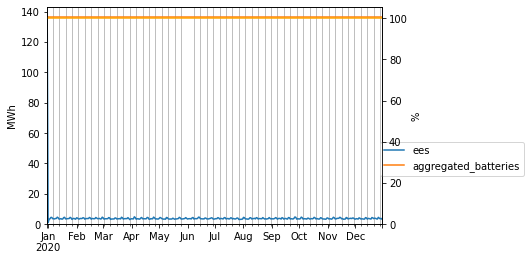

In [18]:
ax = pd.concat([
    -ees_constraints_aggergated*10**-3, pd.Series(aggregated_max_battery*10**-3,level_index)
], axis = 1, keys = ["ees", "aggregated_batteries"]).resample("D").mean().plot(ylabel="MWh", label = 'level_values')

ax.legend(bbox_to_anchor=(0.98,0.2))
ax2 = ax.twinx()
ax2.spines['right'].set_position(('axes',  1))
ax2 = pd.Series(100,level_index).resample("D").mean().plot(color="orange", ylabel="%")

ax.set_ylim(0), ax2.set_ylim(0)
ax.grid('on', which='minor', axis='x' )

plt.savefig(os.path.join(pics, 'ees_battery_comparison.png'), bbox_inches = "tight")

In [19]:
consumption_aggregated =  pd.concat([
    pd.Series(0, index=[index[0]-pd.Timedelta(pd.infer_freq(index))]), df_con.loc[level_index[1:]].sum(1)
              ], axis = 0)
consumption_aggregated.name = "consumption"

power_aggregated = pd.concat([
    pd.Series(0, index=[index[0]-pd.Timedelta(pd.infer_freq(index))]), df_pow.loc[level_index[1:]].sum(1)
              ], axis = 0)

neg_power_aggregated = pd.concat([
    pd.Series(0, index=[index[0]-pd.Timedelta(pd.infer_freq(index))]), df_neg_pow.loc[level_index[1:]].sum(1)
              ], axis = 0)

In [20]:
#aggregation
naive_constraints_aggergated = pd.Series(data=sum(
    df_pro.loc["battery_capacity"][ :profiles]), index=level_index) #all battery capicities

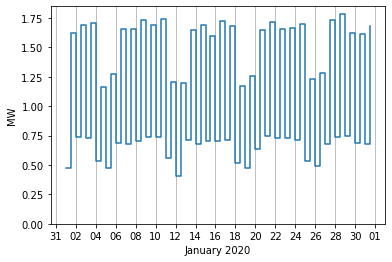

In [21]:
uncontrolled_charge_aggregated =  pd.concat([
    pd.Series(0, index=[index[0]-pd.Timedelta(pd.infer_freq(index))]), uncontrolled_charge_accurate.loc[level_index[1:]]
              ], axis = 0)

ts = uncontrolled_charge_accurate.loc[uncontrolled_charge_accurate.index.month <= 1].resample("12h").mean()*10**-3
fig, ax = plt.subplots(1)

ax.step(ts.index, ts, where="post")
ax.set_ylabel("MW")
ax.set_xlabel("January 2020")
ax.set_ylim(bottom=0)


ax.xaxis.set_major_locator(mdates.DayLocator(interval = 2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))

plt.grid( axis='x' )

plt.savefig(os.path.join(pics, 'uncontrolled_charge.png'), bbox_inches = "tight")

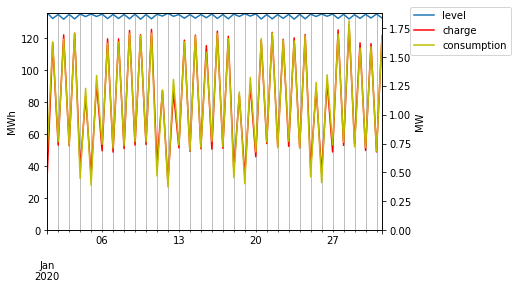

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax = (uncontrolled_level_accurate*10**-3).loc[level_index.month <= 1].resample("12h").mean().plot(label = 'level', ylabel="MWh")

ax2 = ax.twinx()
ax2.spines['right'].set_position(('axes',  1))
ax2 = (uncontrolled_charge_accurate*10**-3).loc[index.month <= 1].resample("12h").mean().plot(label = "charge", color="r", ylabel="MW")
ax2 = (consumption_aggregated*10**-3).loc[level_index.month <= 1].resample("12h").mean().plot( label = "consumption", color="y")


lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2,  loc='best', bbox_to_anchor=(1.4, 1.05))

#ax.xaxis.set_major_locator(mdates.DayLocator(interval = 5))
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%1d'))

ax.set_ylim(0), ax2.set_ylim(0)
ax.grid('on', which='minor', axis='x' )


#plt.savefig(os.path.join(pics, 'uncontrolled_level_1.png'), bbox_inches = "tight")

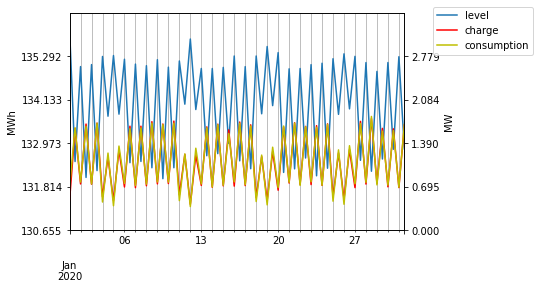

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111)

ts = uncontrolled_level_accurate*10**-3
ax = (ts).loc[level_index.month <= 1].resample("12h").mean().plot(label = 'level', ylabel="MWh")

ax2 = ax.twinx()
ax2.spines['right'].set_position(('axes',  1))
ts_2 = uncontrolled_charge_accurate*10**-3
ts_3 = consumption_aggregated*10**-3
ax2 = (ts_2).loc[index.month <= 1].resample("12h").mean().plot(label = "charge", color="r", ylabel="MW")
ax2 = (ts_3).loc[level_index.month <= 1].resample("12h").mean().plot( label = "consumption", color="y")

##.loc[level_index.day == 3].

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2,  loc='best', bbox_to_anchor=(1.4, 1.05))

ax.grid('on', which='minor', axis='x' )

for i, s in enumerate([ts, ts_3]):
    if i == 0: 
        ax.set_ylim(s.min(), s.max())
        step_size = (s.max() - s.min())/5
        ax.set_yticks(np.arange(s.min(), s.max(), step_size))
    else:
        ax2.set_ylim(s.min(), s.max())
        step_size = (s.max() - s.min())/5
        ax2.set_yticks(np.arange(s.min(), s.max(), step_size))
    



plt.savefig(os.path.join(pics, 'uncontrolled_level.png'), bbox_inches = "tight")

In [24]:
uncontrolled_charge_accurate.max()*10**-3 #MW

2.485626205008433

## Aggregated Optimization

In [25]:
#!pip install pickle5
#import pickle5 as pickle
import pickle
with open("prices_2020", "rb") as fh:
    data = pickle.load(fh)

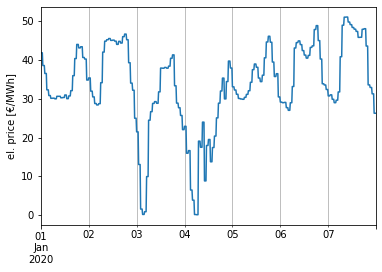

In [26]:
price_mode = "real_price"
prices = data

prices = prices[prices.index >= "2019-12-31 22:45:00+01:00"]

prices.index =  prices.index.map(
    lambda x: pd.to_datetime(x.replace(tzinfo=None))
)
prices = prices[prices.index.drop_duplicates(keep=False)]
prices = prices.reindex(consumption_aggregated.index, method = "ffill") 
prices = prices / (10**3) # €/MWh --> €/kWh

ax = (prices*1000).loc[(level_index.day <= 7) & (level_index.month == 1 )].plot(ylabel="el. price [€/MWh]")

ax.grid('on', which='minor', axis='x' )

plt.savefig(os.path.join(pics, 'prices.png'), bbox_inches = "tight")

In [27]:
#prices = pd.Series(0, prices.index)
#prices[df_con.sum(1).nlargest(1).index] = 1
#price_mode = "artificial_price"

((0.0, 0.05606325), (0.0, 1886.3427292306708))

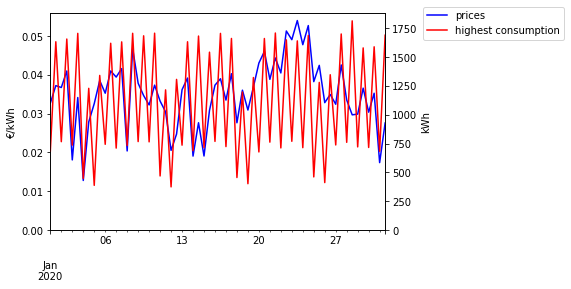

In [28]:
ax = fig.add_subplot(111)

ax = prices.loc[level_index.month <= 1].resample("12h").mean().plot(ylabel="€/kWh", color="b", ylim=(0), label="prices")

ax2 = ax.twinx()
ax2.spines['right'].set_position(('axes',  1))

ax2= df_con.sum(1).loc[index.month <= 1].resample("12h").mean().plot(label = "highest consumption",  ylim=(0), color="r", ylabel="kWh")

##.loc[level_index.day == 3].

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2,  loc='best', bbox_to_anchor=(1.55, 1.05))

ax.set_ylim(0), ax2.set_ylim(0)


Assumptions: 

- same price for (DIS)CHARGE
- 𝑓𝑙𝑒𝑥𝑖𝑏𝑖𝑙𝑖𝑡𝑦 𝑟𝑒𝑣𝑒𝑛𝑢𝑒𝑠 = sum(ees_charging_costs)
- controlled costs = uncontrolled_costs - 𝑙𝑒𝑥𝑖𝑏𝑖𝑙𝑖𝑡𝑦 𝑟𝑒𝑣𝑒𝑛𝑢𝑒𝑠 

In [29]:
agg_solutions = {}

for model_type in ["naive", "ees"]: 

    #Initialize model
    m_agg = pyo.ConcreteModel()

    #initialize sets
    m_agg.t = pyo.Set(initialize = ees_constraints_aggergated.index, ordered = True)

    m_agg.consumption_aggregated = pyo.Param(m_agg.t, initialize=consumption_aggregated.to_dict())
    m_agg.power = pyo.Param(m_agg.t, initialize=power_aggregated.to_dict()) 
    m_agg.neg_power = pyo.Param(m_agg.t, initialize=neg_power_aggregated.to_dict()) 

    m_agg.LEVEL = pyo.Var(m_agg.t, within = pyo.Reals)
    m_agg.CHARGE = pyo.Var(m_agg.t, within = pyo.NonNegativeReals)
    m_agg.DISCHARGE_PHYS = pyo.Var(m_agg.t, within = pyo.NonNegativeReals)
    m_agg.DISCHARGE_WAIT = pyo.Var(m_agg.t, within = pyo.NonNegativeReals)

    if model_type == "ees":
        m_agg.ees_min = pyo.Param(m_agg.t, initialize=ees_constraints_aggergated.to_dict()) 
        m_agg.uncontrolled_charge = pyo.Param(m_agg.t, initialize=uncontrolled_charge_aggregated.to_dict()) 
       
    if model_type == "ees":
        #recursive level
        def recursive_level(m_agg, t):
            if t == level_index[0]:
                return m_agg.LEVEL[t] == (m_agg.CHARGE[t] - m_agg.DISCHARGE_WAIT[t] - m_agg.DISCHARGE_PHYS[t])*step_duration   
            else:
                return m_agg.LEVEL[t] == m_agg.LEVEL[pd.Timestamp(t) - 
                                                 pd.Timedelta(pd.infer_freq(index))] + (
                    m_agg.CHARGE[t] - m_agg.DISCHARGE_WAIT[t] - m_agg.DISCHARGE_PHYS[t]) * step_duration   
            
    else:
        def final_level(m_agg, t):
            if t == index[-1]:
                return m_agg.LEVEL[t] == level_T_agg
            else: 
                return pyo.Constraint.Skip
        m_agg.Final_level = pyo.Constraint(m_agg.t, rule=final_level)
        
        def recursive_level(m_agg, t):
            if t == level_index[0]: 
                return m_agg.LEVEL[t] == level_0_agg + (m_agg.CHARGE[t]- m_agg.consumption_aggregated[t] - m_agg.DISCHARGE_PHYS[t] )*step_duration   
            else:
                return m_agg.LEVEL[t] == m_agg.LEVEL[pd.Timestamp(t) - 
                                                 pd.Timedelta(pd.infer_freq(index))] + (
                    m_agg.CHARGE[t] - m_agg.consumption_aggregated[t] - m_agg.DISCHARGE_PHYS[t]) * step_duration 
            
       
    m_agg.Recursive_level = pyo.Constraint(m_agg.t, rule = recursive_level)
    
    def level_constraint(m_agg, t):
        if model_type=="ees":
            return m_agg.LEVEL[t] >= m_agg.ees_min[t] 
        else:
            return m_agg.LEVEL[t] <= aggregated_max_battery
    m_agg.Level_constraint = pyo.Constraint(m_agg.t, rule=level_constraint)
    
    def level_constraint_2(m_agg, t):
        if model_type=="ees":
            return m_agg.LEVEL[t] <= 0
        else:
            return m_agg.LEVEL[t] >= 0
    m_agg.Level_constraint_2 = pyo.Constraint(m_agg.t, rule=level_constraint_2)
    
    if (model_type == "naive")  & (flex=="constrained"): ####
        dep_index = consumption_aggregated[(consumption_aggregated==0) & (consumption_aggregated.shift(-1) > 0) == True].index
        m_agg.t_dep = pyo.Set(initialize = dep_index, ordered = True)

        def full_before_next_trip(m_agg, t_dep):
            return m_agg.LEVEL[t_dep] >= uncontrolled_level_accurate[dep_index].loc[t_dep]
        m_agg.Full_before_next_trip = pyo.Constraint(m_agg.t_dep, rule=full_before_next_trip)
                    
    def power_charge_max(m_agg, t):
        return m_agg.CHARGE[t] <= m_agg.power[t]   
    m_agg.Power_charge_max = pyo.Constraint(m_agg.t, rule=power_charge_max)

    if model_type == "ees":
        def power_discharge_consumption_max(m_agg, t):
            return m_agg.DISCHARGE_WAIT[t] <=  m_agg.uncontrolled_charge[t] 
        m_agg.Power_discharge_consumption_max = pyo.Constraint(m_agg.t, rule=power_discharge_consumption_max)
    
    def power_discharge_phys_max(m_agg, t):
        if V2G == True:
            return m_agg.DISCHARGE_PHYS[t] <= m_agg.neg_power[t] 
        else: 
            return m_agg.DISCHARGE_PHYS[t] == 0
            
    m_agg.Power_discharge_phys_max = pyo.Constraint(m_agg.t, rule=power_discharge_phys_max)

    # objective function
    if model_type == "ees":
        def min_ees_costs(m_agg): 
            return sum(
                (m_agg.CHARGE[t]-m_agg.DISCHARGE_WAIT[t]-m_agg.DISCHARGE_PHYS[t]
                ) * prices[t] *step_duration 
                for t in m_agg.t
            ) 
        m_agg.Obj_min_ees_costs = pyo.Objective(rule=min_ees_costs, sense=pyo.minimize)
    else:
        def min_naive_costs(m_agg): 
            return sum(
                (m_agg.CHARGE[t] - m_agg.DISCHARGE_PHYS[t]) * prices[t] *step_duration 
                for t in m_agg.t
            ) 
        m_agg.Obj_min_naive_costs = pyo.Objective(rule=min_naive_costs, sense=pyo.minimize)
        
    #find solver
    solvername='glpk'

    #prepare solver
    optimizer = opt.SolverFactory(solvername) 
    solved_model = optimizer.solve(m_agg, tee=True)        
    
    agg_solutions[model_type] = {}
    agg_solutions[model_type]["costs"] = solved_model['Problem']()['Lower bound']
    agg_solutions[model_type]["CHARGE"] = pd.DataFrame.from_dict(m_agg.CHARGE.extract_values(), orient='index', columns = [model_type])
    if model_type == "ees":
        agg_solutions[model_type]["DISCHARGE"] = pd.DataFrame.from_dict(m_agg.DISCHARGE_WAIT.extract_values(), orient='index', columns = [model_type]) + pd.DataFrame.from_dict(m_agg.DISCHARGE_PHYS.extract_values(), orient='index', columns = [model_type])
    else:
        agg_solutions[model_type]["DISCHARGE"] = pd.DataFrame.from_dict(m_agg.DISCHARGE_PHYS.extract_values(), orient='index', columns = [model_type])
    agg_solutions[model_type]["LEVEL"] = pd.DataFrame.from_dict(m_agg.LEVEL.extract_values(), orient='index', columns = [model_type])

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmp38cva5ys.glpk.raw --wglp
 C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmprpz37195.glpk.glp --cpxlp C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpa5leckkm.pyomo.lp
Reading problem data from 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpa5leckkm.pyomo.lp'...
175398 rows, 105124 columns, 280520 non-zeros
981895 lines were read
Writing problem data to 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmprpz37195.glpk.glp'...
806190 lines were written
GLPK Simplex Optimizer, v4.65
175398 rows, 105124 columns, 280520 non-zeros
Preprocessing...
35020 rows, 35021 columns, 70040 non-zeros
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 35020
      0: obj =   2.935030148e+05 inf =   5.095e+07 (382)
   4920: obj =   2.927665324e+05 inf =   2.663e+07 (276)
   9776:

def plot_aggregated_results(model_type):
    obversvations = 100#len(ees_constraints_aggergated)
    x = level_index[10:obversvations]
    fig, ax = plt.subplots(3)
    ax[0].step(x, 
               pyo.value(agg_solutions[model_type]["CHARGE"].values[10:obversvations]), where="pre")
    ax[0].set_title("{}_charging".format(model_type))
    
    
    ax[1].step(x, 
               pyo.value(agg_solutions[model_type]["DISCHARGE"].values[10:obversvations]), where="pre")
    ax[1].set_title("{}_discharging".format(model_type))
    
    
    ax[2].plot(x, 
               pyo.value(agg_solutions[model_type]["LEVEL"].values[10:obversvations]))
    ax[2].set_title("{}_level".format(model_type))
    ax[2].set_ylabel("kWh")
    
    
    for i in range(0,2):
        ax[i].set_ylabel("kWh/15min")
        ax[i].set_xticks(pd.date_range(x[0], x[-1], freq="D"))
        #plt.set_xticklabels(rotation= 45)
        plt.xticks(rotation= 45)
    fig.autofmt_xdate(rotation=45)


    plt.tight_layout()
    plt.show()
    
plot_aggregated_results("ees")
plot_aggregated_results("naive")

# Analysis

In [30]:
agg_overest_solutions = {}

for model_type in ["m_early_agg", "m_late_agg"]:
    #Initialize model
    m_agg = pyo.ConcreteModel()

    #initialize sets
    m_agg.t = pyo.Set(initialize = ees_constraints_aggergated.index, ordered = True)

    m_agg.consumption_aggregated = pyo.Param(m_agg.t, initialize=consumption_aggregated.to_dict())
    m_agg.power = pyo.Param(m_agg.t, initialize=power_aggregated.to_dict()) 
    m_agg.neg_power = pyo.Param(m_agg.t, initialize=neg_power_aggregated.to_dict()) 

    m_agg.LEVEL = pyo.Var(m_agg.t, within = pyo.NonNegativeReals, bounds=(
        0, aggregated_max_battery))
    m_agg.CHARGE = pyo.Var(m_agg.t, within = pyo.NonNegativeReals)
    m_agg.DISCHARGE = pyo.Var(m_agg.t, within = pyo.NonNegativeReals)
    
    if (model_type == "m_late_agg")  & (flex=="constrained"): ###
        dep_index = consumption_aggregated[(consumption_aggregated==0) & (consumption_aggregated.shift(-1) > 0) == True].index
        m_agg.t_dep = pyo.Set(initialize = dep_index, ordered = True)
        def full_before_next_trip(m_agg, t_dep):
            return m_agg.LEVEL[t_dep] >= uncontrolled_level_accurate[dep_index].loc[t_dep]
        m_agg.Full_before_next_trip = pyo.Constraint(m_agg.t_dep, rule=full_before_next_trip)
        
        
    #level constraints
    def recursive_level(m_agg, t):
        if t == level_index[0]:
            return m_agg.LEVEL[t] == level_0_agg + m_agg.CHARGE[t] - m_agg.consumption_aggregated[t]
        else:    
            return m_agg.LEVEL[t] == m_agg.LEVEL[pd.Timestamp(t) - 
                                             pd.Timedelta(pd.infer_freq(level_index))] + (
                m_agg.CHARGE[t] - m_agg.consumption_aggregated[t] - m_agg.DISCHARGE[t] )
    m_agg.Recursive_level = pyo.Constraint(m_agg.t, rule = recursive_level)
    
    def final_level(m_agg, t):
        if t == index[-1]:
            return m_agg.LEVEL[t] == level_T_agg
        else: 
            return pyo.Constraint.Skip
    m_agg.Final_level = pyo.Constraint(m_agg.t, rule=final_level)
    
    #bidirectional charging 
    def neg_power_min(m_agg, t):
        if V2G == True:
            return m_agg.DISCHARGE[t] <= m_agg.neg_power[t]
        else: 
            return m_agg.DISCHARGE[t] == 0
    m_agg.Neg_power_min_restriction = pyo.Constraint(m_agg.t, rule=neg_power_min)

    def power_max(m_agg, t):
        return m_agg.CHARGE[t] <= m_agg.power[t]   
    m_agg.Power_max_restriction = pyo.Constraint(m_agg.t, rule=power_max)
    
    def final_level(m_agg, t):
        if t == index[-1]:
            return m_agg.LEVEL[t] == level_T_agg
        else: 
            return pyo.Constraint.Skip
    m_agg.Final_level = pyo.Constraint(m_agg.t, rule=final_level)

    # objective function late
    def battery_level_sum(m_agg, t): 
        return sum(m_agg.LEVEL[t] for t in m_agg.t) 
    if model_type == "m_late_agg":
        sense = pyo.minimize
    elif model_type == "m_early_agg":
        sense = pyo.maximize     
    m_agg.Obj = pyo.Objective(rule=battery_level_sum, sense=sense)

    #find solver
    solvername='glpk'

    #prepare solver
    optimizer = opt.SolverFactory(solvername) 
    solved_model = optimizer.solve(m_agg, tee=True)        

    #store data in dictionary
    agg_overest_solutions[model_type] = pd.DataFrame.from_dict(
        m_agg.LEVEL.extract_values(), orient='index')[0]

    'pyomo.core.base.constraint.IndexedConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpp5vsxfu8.glpk.raw --wglp
 C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmp24eolldw.glpk.glp --cpxlp C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpd_2a90iy.pyomo.lp
Reading problem data from 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpd_2a90iy.pyomo.lp'...
105125 rows, 105124 columns, 210246 non-zeros
665793 lines were read
Writing problem data to 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmp24eolldw.glpk.glp'...
560361 lines were written
GLPK Simplex Optimizer, v4.65
105125 rows, 105124 columns, 210246 non-zeros
Preprocessing...
35020 rows, 35021 columns, 70040 non-zeros
Scalin

In [31]:
#overestimation in kWh how much could be shifted from uncontrolled charging?
overestimation_dict = {}

overestimation = 1 + (
    (agg_overest_solutions["m_late_agg"] - agg_overest_solutions["m_early_agg"]).sum()
    - ees_constraints_aggergated.sum()
) / ees_constraints_aggergated.sum()

print(
    "potential overestimation factor: " + str(
        overestimation) + " : " + str((
    (agg_overest_solutions["m_late_agg"] - agg_overest_solutions["m_early_agg"]).sum()
    - ees_constraints_aggergated.sum()
) / ees_constraints_aggergated.sum()*100) + " %"
)
                                                  
overestimation_dict[f'profiles: {profiles}, steps: {time_steps}'] =  overestimation 

potential overestimation factor: 28.030257337139602 : 2703.02573371396 %


#df = pd.DataFrame().from_dict(overestimation_dict, orient="index")
df_profiles = df.iloc[:7]
df_profiles.index = [int(
    i.split(":")[1].split(",")[0]
)
 for i in df_profiles.index]

df_profiles.to_pickle("profiles_overestimation")
df_profiles.plot()
plt.legend(["time_steps: 673"])

df_time_steps = df.iloc[7:]
df_time_steps.index = [int(
    i.split(",")[1].split(":")[1]
)
 for i in df_time_steps.index]

df_time_steps.to_pickle("time_step_overestimation")
df_time_steps.plot()
plt.legend(["profiles: 3311"])

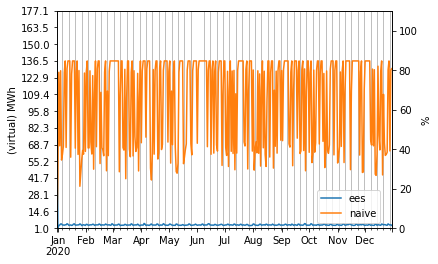

In [32]:
ts = pd.concat([
    -ees_constraints_aggergated*10**-3 ,((agg_overest_solutions["m_early_agg"] - agg_overest_solutions["m_late_agg"])*10**-3)
], axis = 1, keys = ["ees", "naive"]).resample("D").mean()

ax = ts.plot(ylabel="(virtual) MWh")

ax.legend(bbox_to_anchor=(0.98,0.2))

ax2 = ax.twinx()
ax2.spines['right'].set_position(('axes',  1))

ts_2 = pd.Series(100,level_index).resample("D").mean()
ax2 = ts_2.plot(alpha=0, ylabel="%")

ax.set_ylim(0), ax2.set_ylim(0)


ax.grid('on', which='minor', axis='x' )

for i, s in enumerate([ts, ts_2]):
    if i == 0: 
        ax.set_ylim(s.min()[0], s.max()[0])
        step_size = (s.max()[0] - s.min()[0])/10
        ax.set_yticks(np.arange(s.min()[0], s.max()[0]+50, step_size))
    else:
        ax2.set_ylim(0, 110)
        step_size = 100/5
        ax2.set_yticks(np.arange(0,110, step_size))

plt.savefig(os.path.join(pics, 'level_comparison_size_ts.png'), bbox_inches = "tight")

In [33]:
ees_constraints_aggergated.sum()*10**-6

-130.97958949651246

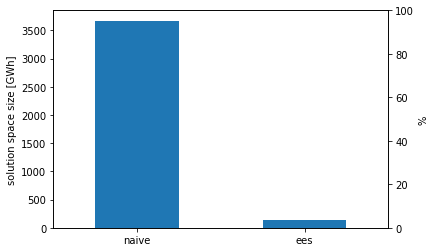

In [34]:
ts = pd.DataFrame([
    (agg_overest_solutions["m_early_agg"] - agg_overest_solutions["m_late_agg"]).sum()*10**-6,
    -ees_constraints_aggergated.sum()*10**-6
], ["naive", "ees"])

ax = ts.plot.bar(rot=0, legend=False )


ax.set_ylabel("solution space size [GWh]")

ax2 = ax.twinx()

ax2.spines['right'].set_position(('axes',  1))

ax2.set_ylim(0,100)
ax2.set_ylabel("%")

ax.grid('on', which='minor', axis='x' )

plt.savefig(os.path.join(pics,'level_comparison_size_bar.png'), bbox_inches = "tight")


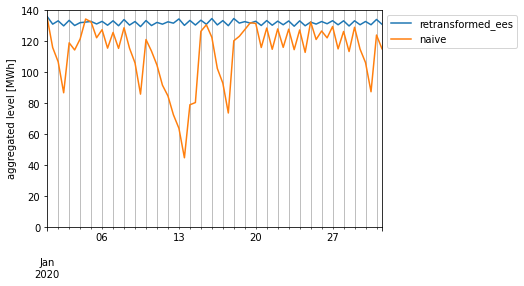

In [35]:
#controlled charging (physical) = uncontrolled charging - ees_dis + ee_scharging
#fig, ax = plt.subplots()

retransformed_ees_level = pd.concat([
    uncontrolled_level_accurate, agg_solutions["ees"]["LEVEL"]
], axis=1).sum(1)
retransformed_ees_level.name = "retransformed_ees"

ax = (pd.concat([
    retransformed_ees_level, agg_solutions["naive"]["LEVEL"]
], axis=1)*10**-3).loc[level_index.month <= 1].resample("12h").mean().plot(ylabel="aggregated level [MWh]", ylim=0)

#.loc[level_index.day <= 7]
ax.grid('on', which='minor', axis='x' )

plt.legend(bbox_to_anchor=(1.0, 1.0))


#fig.tight_layout()
plt.savefig(os.path.join(pics, price_mode,'opt_level_comparison_long.png'), bbox_inches = "tight")#week

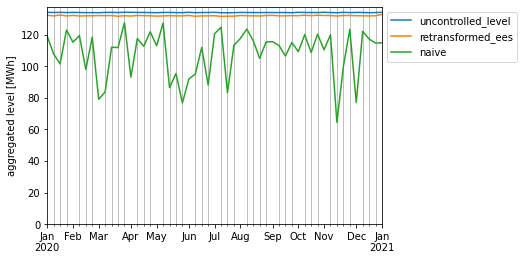

In [36]:
ax = (pd.concat([
    uncontrolled_level_accurate, retransformed_ees_level, agg_solutions["naive"]["LEVEL"]
], axis=1)*10**-3).resample("W").mean().plot(ylabel="aggregated level [MWh]", ylim=0)

ax.grid('on', which='minor', axis='x' )

plt.legend(bbox_to_anchor=(1.0, 1.0))

plt.savefig(os.path.join(pics, price_mode,'shifted_energy.png'), bbox_inches = "tight") #long, week, day_3

In [37]:
-agg_solutions["ees"]["LEVEL"].sum()*10**-6

ees    71.365177
dtype: float64

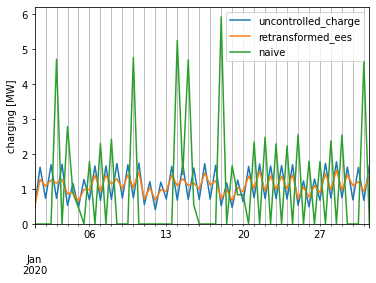

In [38]:
#controlled charging (physical) = uncontrolled charging - ees_dis + ee_scharging

retransformed_ees_charge = pd.concat([
    uncontrolled_charge_accurate.loc[level_index[1:]], agg_solutions["ees"]["CHARGE"], - agg_solutions["ees"]["DISCHARGE"]
], axis=1).sum(1)

charge_list = [agg_solutions["naive"]["CHARGE"]]
if V2G==True: charge_list.append(- agg_solutions["naive"]["DISCHARGE"])
naive_dis_charge = pd.concat(charge_list, axis=1).sum(1)

retransformed_ees_charge.name, naive_dis_charge.name = "retransformed_ees", "naive"

df_list = [uncontrolled_charge_accurate, retransformed_ees_charge, naive_dis_charge]
df_list = [df*10**-3 for df in df_list]
ax = pd.concat(df_list, axis=1).loc[level_index.month <= 1].resample("12h").mean().plot(ylabel="charging [MW]", ylim=(0))
ax.grid('on', which='minor', axis='x' )
#.loc[level_index.day <= 7]
plt.legend(bbox_to_anchor=(1.0, 1.0))

plt.savefig(os.path.join(pics, price_mode,'all_charging_day_3.png'), bbox_inches = "tight") #long, week, day_3

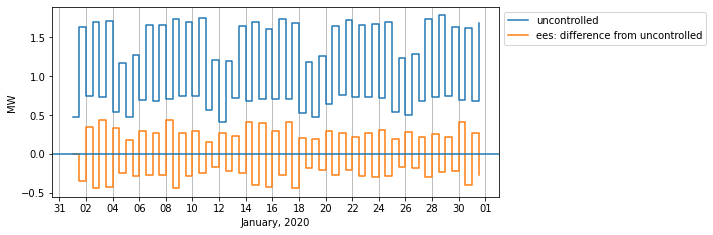

In [39]:
fig, ax = plt.subplots(figsize=(8, 3.5))

ts =  (pd.concat([
    uncontrolled_charge_accurate, agg_solutions["ees"]["CHARGE"]-agg_solutions["ees"]["DISCHARGE"]
], axis=1)*10**-3).loc[level_index.month <= 1].resample("12h").mean()


ax.step(ts.index, ts, where="post")
ax.set_ylabel("MW")
ax.set_xlabel("January, 2020")
plt.axhline(y=0)
ax.xaxis.set_major_locator(mdates.DayLocator(interval = 2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))

ax.legend(["uncontrolled", "ees: difference from uncontrolled"], bbox_to_anchor=(1.0, 1.0))

plt.grid( axis='x' )

plt.savefig(os.path.join(pics, 'shifted_charge.png'), bbox_inches = "tight")

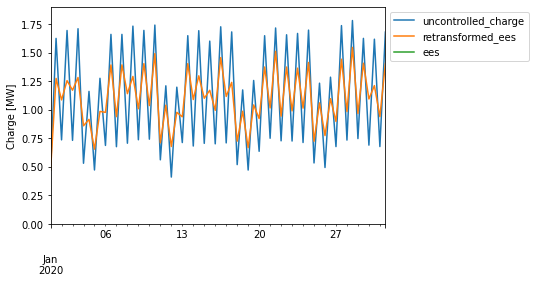

In [40]:
ax = (pd.concat([
    uncontrolled_charge_accurate, retransformed_ees_charge, -agg_solutions["ees"]["CHARGE"]
], axis=1)*10**-3).loc[level_index.month <= 1].resample("12h").mean().plot(ylabel="Charge [MW]", ylim=0)

plt.legend(bbox_to_anchor=(1.0, 1.0))

plt.savefig(os.path.join(pics, price_mode,'shifted_energy.png'), bbox_inches = "tight") #long, week, day_3


In [41]:
#plausibility: charging the same in all strategies? 
pd.concat([
    uncontrolled_charge_accurate, retransformed_ees_charge, naive_dis_charge.iloc[1:]
], axis=1).sum(0)

uncontrolled_charge    3.867635e+07
retransformed_ees      3.867635e+07
naive                  3.867635e+07
dtype: float64

In [42]:
pd.concat([retransformed_ees_level, agg_solutions["naive"]["LEVEL"]], axis=1).iloc[-1]

retransformed_ees    136451.05
naive                136451.05
Name: 2020-12-30 23:45:00, dtype: float64

## Cost

In [43]:
uncontrolled_costs = sum([
    uncontrolled_charge_accurate[i] * prices[i] for i in index
])
controlled_costs_ees = sum([
    retransformed_ees_charge[i] * prices[i] for i in index
])
controlled_costs_naive = sum([
    naive_dis_charge[i] * prices[i] for i in index
])

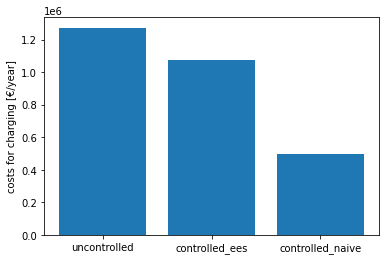

<Figure size 432x288 with 0 Axes>

In [44]:
#costs
fig, ax = plt.subplots()

plt.bar(x = ["uncontrolled", "controlled_ees", "controlled_naive"],  height=[
    uncontrolled_costs, controlled_costs_ees, controlled_costs_naive
])
plt.ylabel("costs for charging [€/year]")
plt.show()

fig.tight_layout()
plt.savefig(os.path.join(pics, price_mode,'costs.png')) 

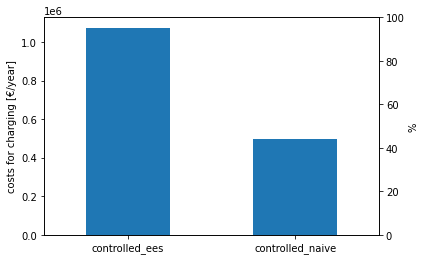

In [45]:

ax = pd.DataFrame([
    controlled_costs_ees, controlled_costs_naive
], ["controlled_ees", "controlled_naive"]).plot.bar(rot=0, legend=False )


ax.set_ylabel("costs for charging [€/year]")

ax2 = ax.twinx()

ax2.spines['right'].set_position(('axes',  1))

ax2.set_ylim(0,100)
ax2.set_ylabel("%")


plt.savefig(os.path.join(pics, price_mode,'costs_percent.png'), bbox_inches = "tight") 

## Scaling

In [46]:
fleeet_size = 10**6 